# Trial Onset ~ all frequencies: LL10

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra


In [2]:
## Prep paths ##

subject = 'LL10'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

# load preproc functions
%run ../../scripts/preproc_functions.py

In [3]:
## Load Neural Data

# load
trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if  x]

# onlt good epochs
trial_onset_epochs = trial_onset_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_11392/973766942.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [4]:
## Dictionary of electrode locations ##

# Pull mapping ROI to elecs
%run ../../scripts/roi.py
ROIs = ROIs[subject]

## prep lists

# limbic ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []
sgACC_list = []
sgACC_names = [] 
sgACC_indices = []
dACC_list = []
dACC_names = [] 
dACC_indices = []
sfg_list = []
sfg_names = [] 
sfg_indices = []
mfg_list = []
mfg_names = [] 
mfg_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in trial_onset_epochs.info['ch_names']]
bidx = len(trial_onset_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
    if pairs_name[ix][0] in ROIs['sgACC'] or pairs_name[ix][1] in ROIs['sgACC']:
        sgACC_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        sgACC_names.append(pairs_name[ix])
        sgACC_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dACC'] or pairs_name[ix][1] in ROIs['dACC']:
        dACC_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dACC_names.append(pairs_name[ix])
        dACC_indices.append(ix)        
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['sfg'] or pairs_name[ix][1] in ROIs['sfg']:
        sfg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        sfg_names.append(pairs_name[ix])
        sfg_indices.append(ix)   
    if pairs_name[ix][0] in ROIs['mfg'] or pairs_name[ix][1] in ROIs['mfg']:
        mfg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        mfg_names.append(pairs_name[ix])
        mfg_indices.append(ix)     
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [5]:
# Print and check frequencies
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

# Main Regions of Interest

## Hippocampus

In [6]:
hc_list

['RH1-RH2', 'RH2-RH3', 'LH1-LH2', 'LH2-LH3']

In [7]:
# only ROI of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(hc_list)


In [8]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [9]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:   32.8s remaining:   32.8s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:   38.5s finished


Not setting metadata


In [10]:
# Crop to time of interest

roi_pres_TFR.crop(tmin = -1, tmax = 5)

<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 211, channels : 4, ~1.55 GB>

In [11]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/trial_onset/hc-tfr.h5", overwrite = True)

In [12]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


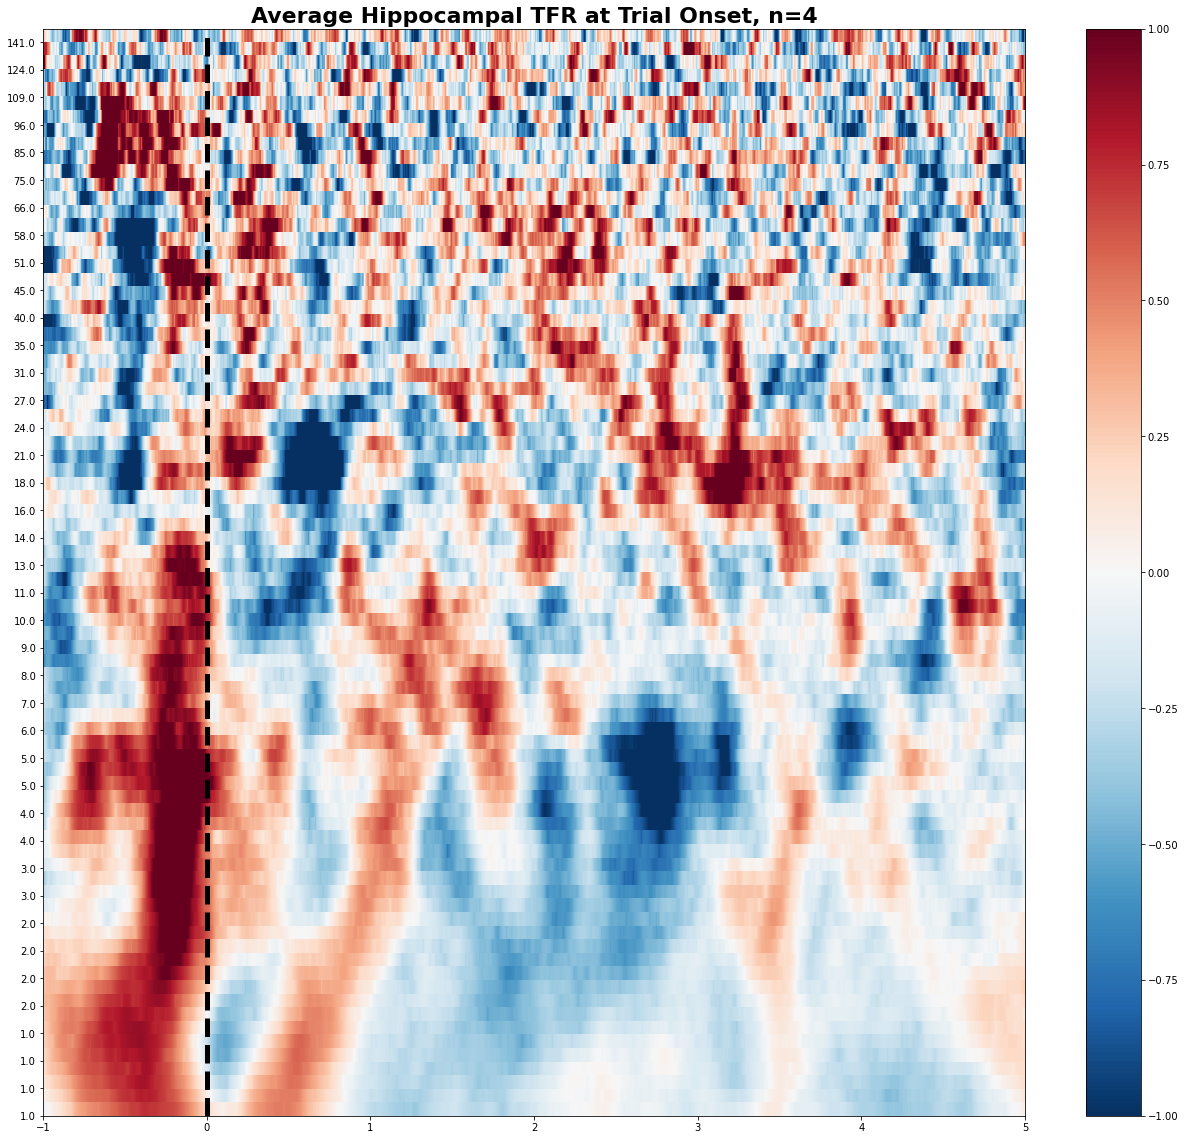

In [13]:
# Plot TFR
plot_average_tfr(roi_pres_TFR, f"Average Hippocampal TFR at Trial Onset, n={len(hc_list)}", subject, 'hc_trialonset')


## Individual Channels

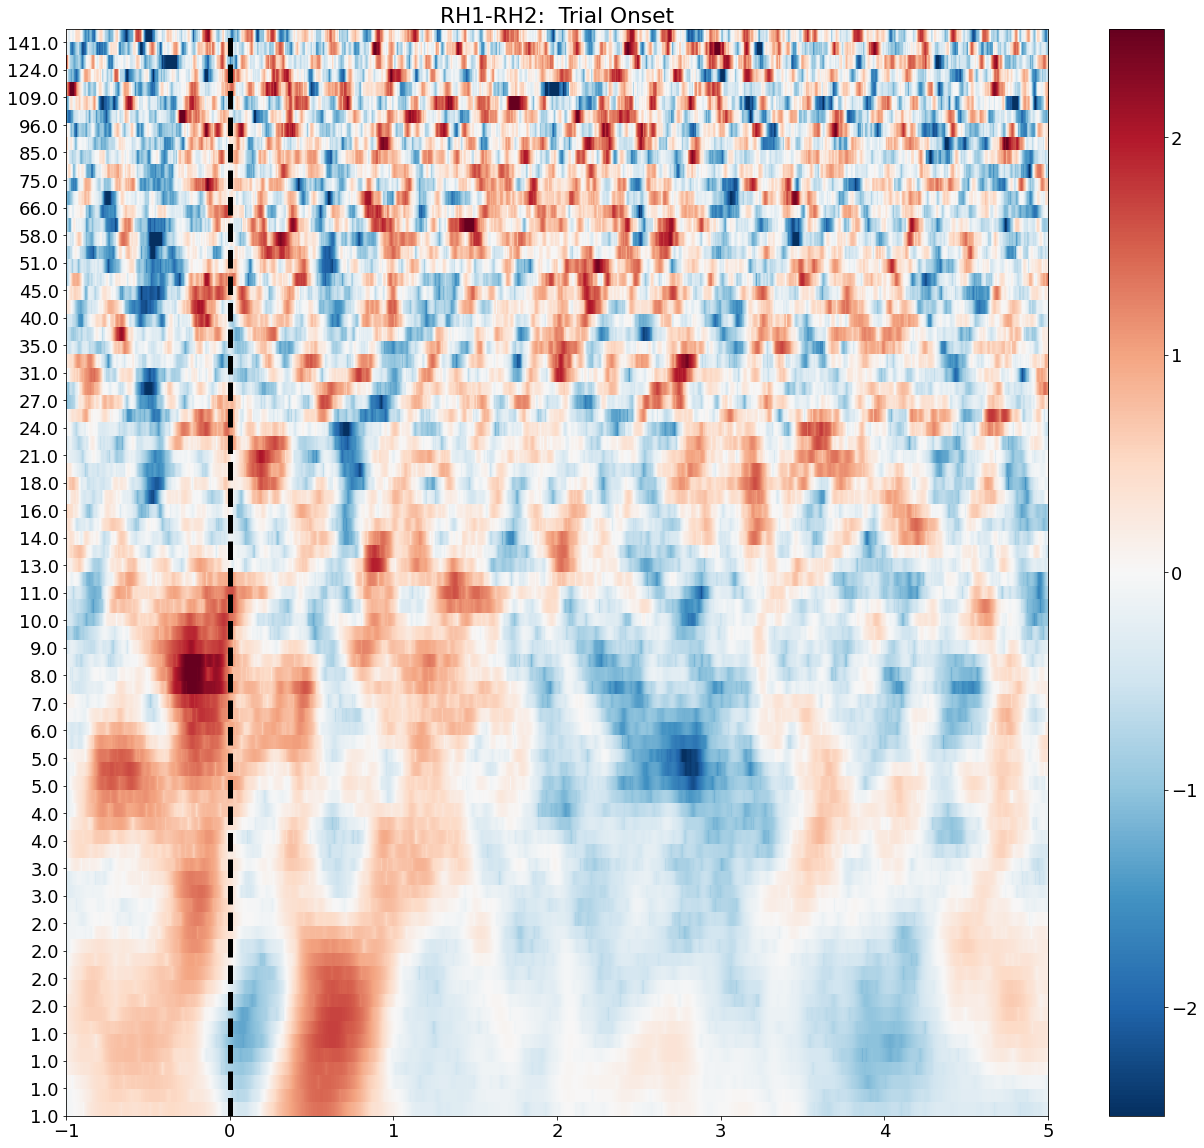

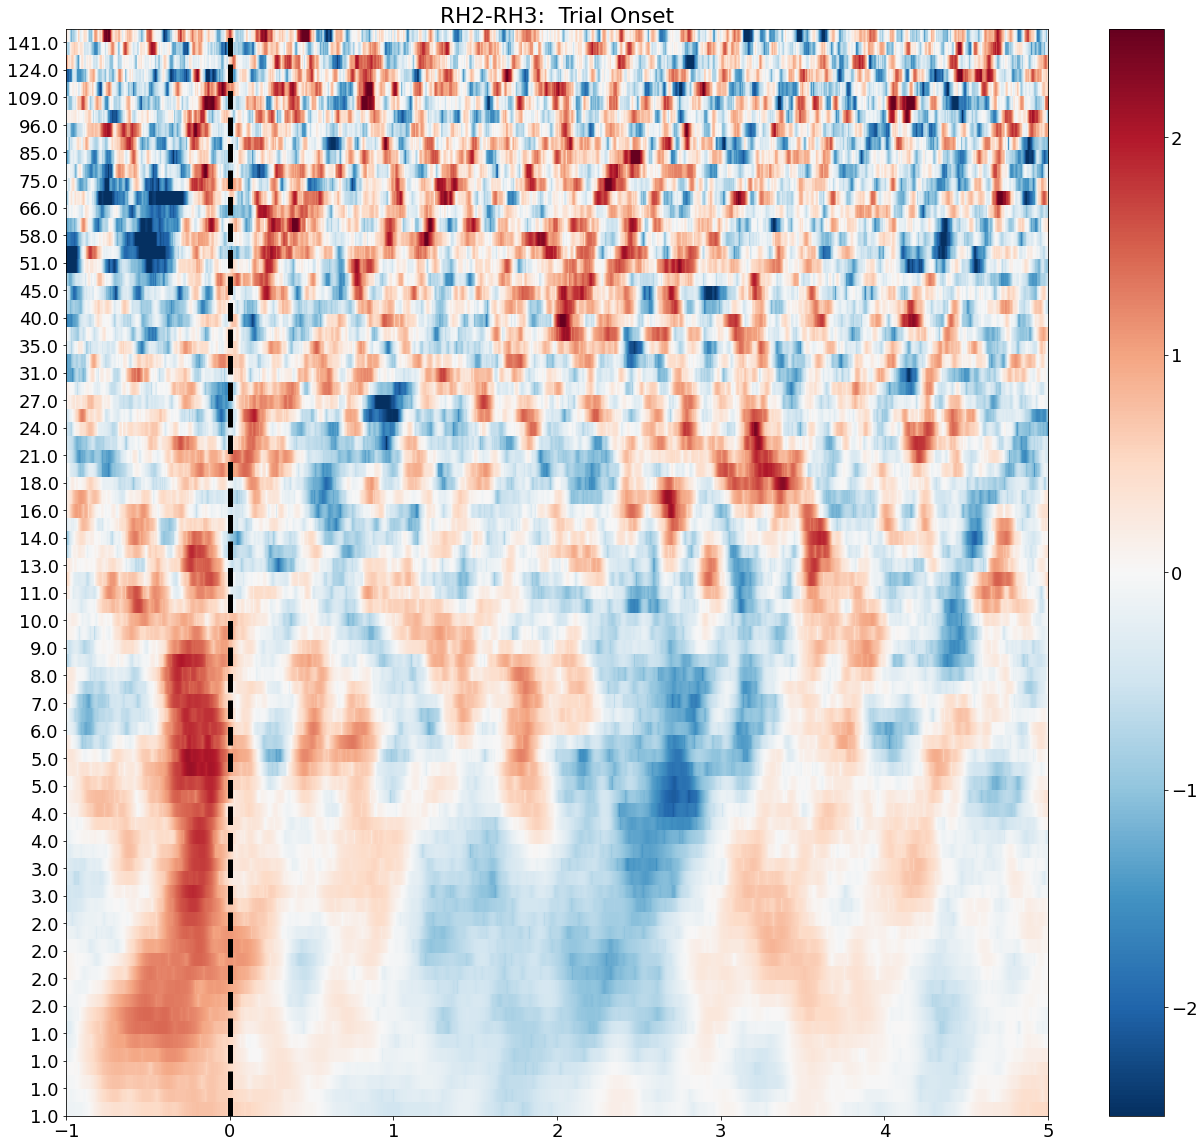

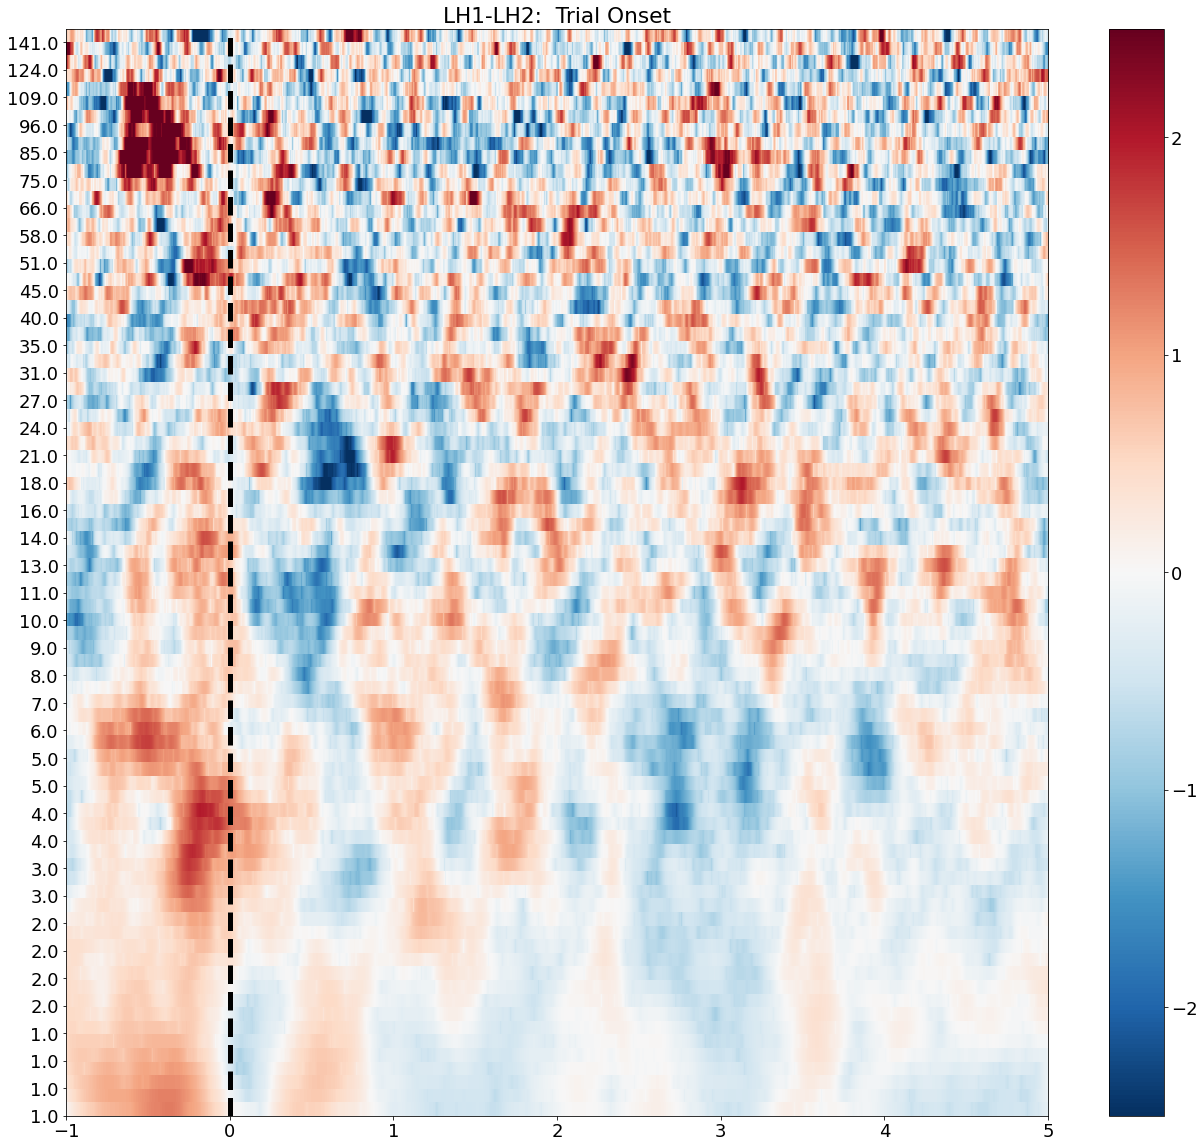

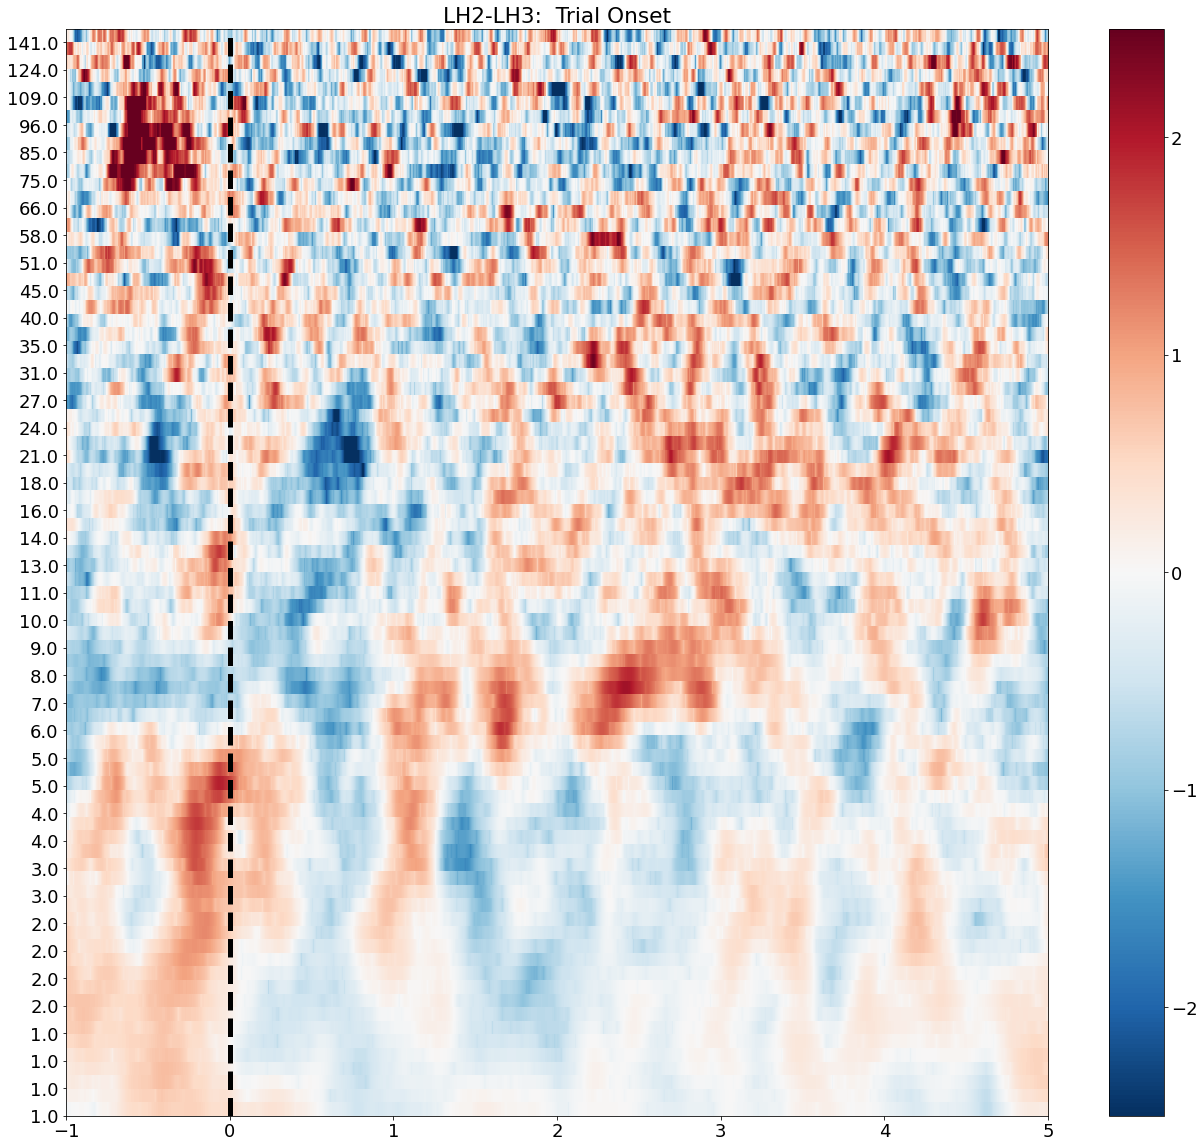

In [14]:
# Plot Channel TFR
for chix, ch in enumerate(roi_pres_TFR.ch_names):

    plot_channel_tfr(roi_pres_TFR, chix, ch, 'Trial Onset')
    


## Export freq data locked to turn around time to csvs

# OFC

In [15]:
ofc_list

['ROF1-ROF2']

In [16]:
# only roi of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(ofc_list)


In [17]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [18]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


In [19]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 211, channels : 1, ~395.8 MB>

In [20]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/trial_onset/ofc-tfr.h5", overwrite = True)

In [21]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


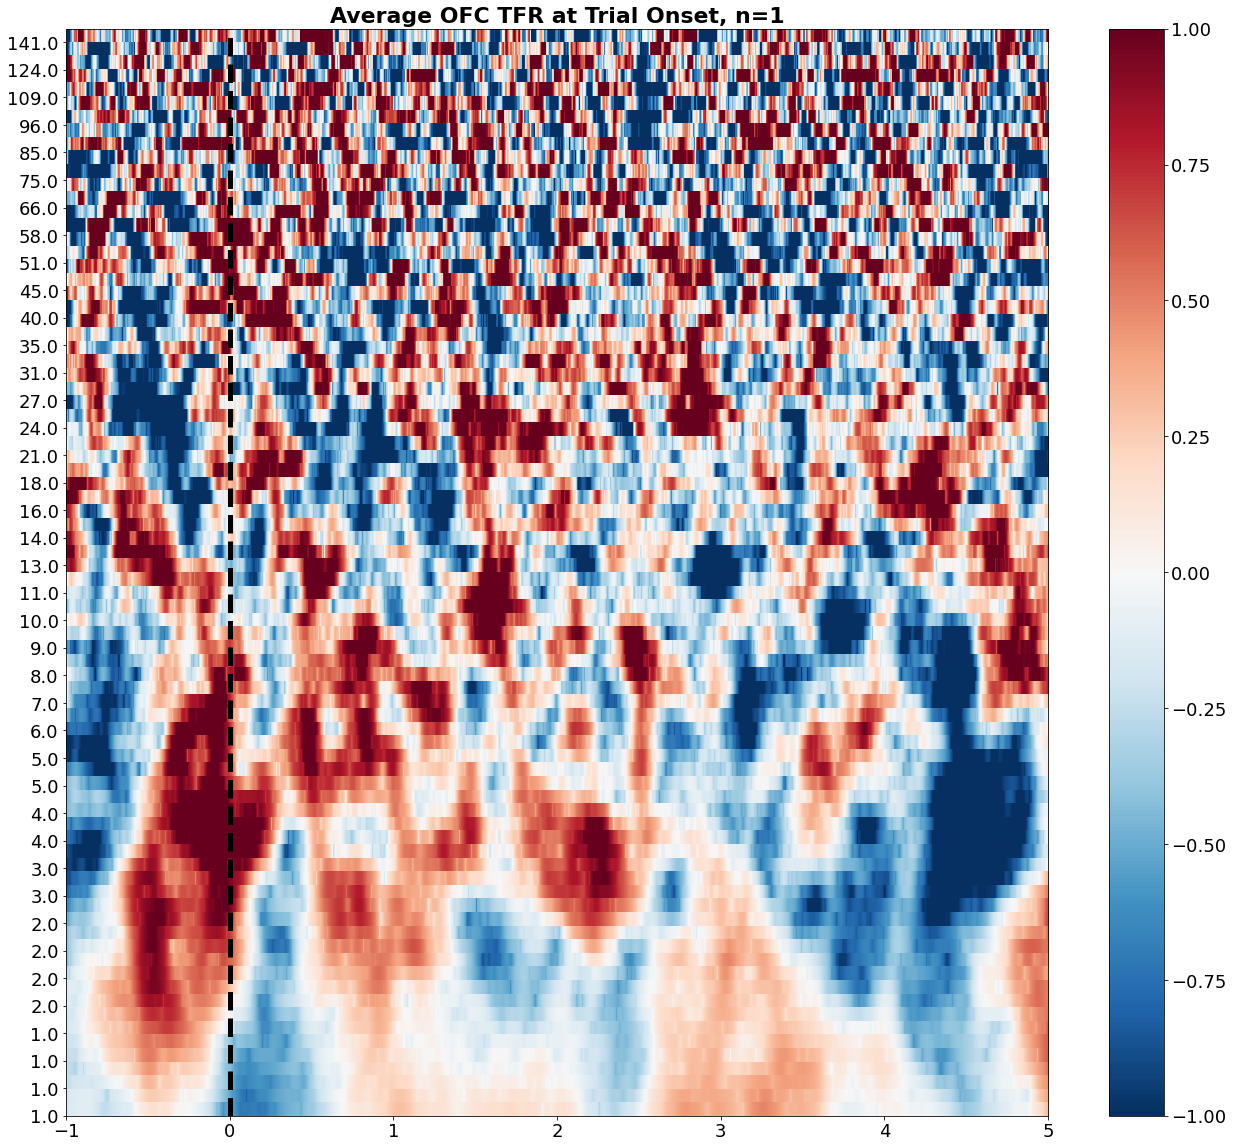

In [22]:
# Plot TFR
plot_average_tfr(roi_pres_TFR, f"Average OFC TFR at Trial Onset, n={len(ofc_list)}", subject, 'ofc_trialonset')


### Individual Channels

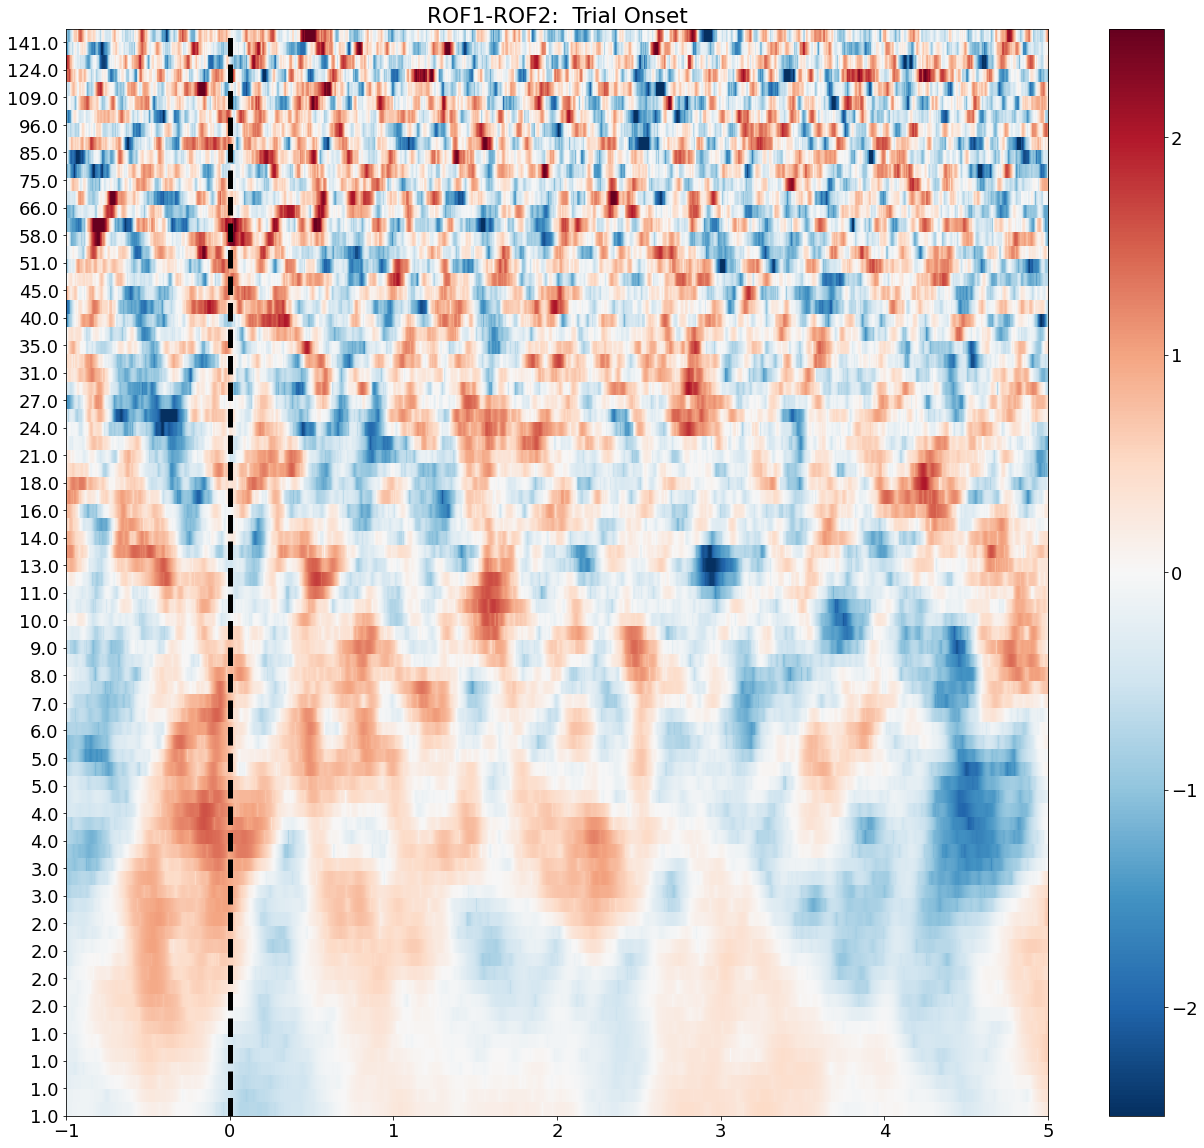

In [23]:
# Plot Channel TFR
for chix, ch in enumerate(roi_pres_TFR.ch_names):

    plot_channel_tfr(roi_pres_TFR, chix, ch, 'Trial Onset')
    


# Amygdala

In [24]:
amyg_list

['RA2-RA3']

In [25]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(amyg_list)


In [26]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [27]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


In [28]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 211, channels : 1, ~395.8 MB>

In [29]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/trial_onset/amyg-tfr.h5", overwrite = True)

In [30]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


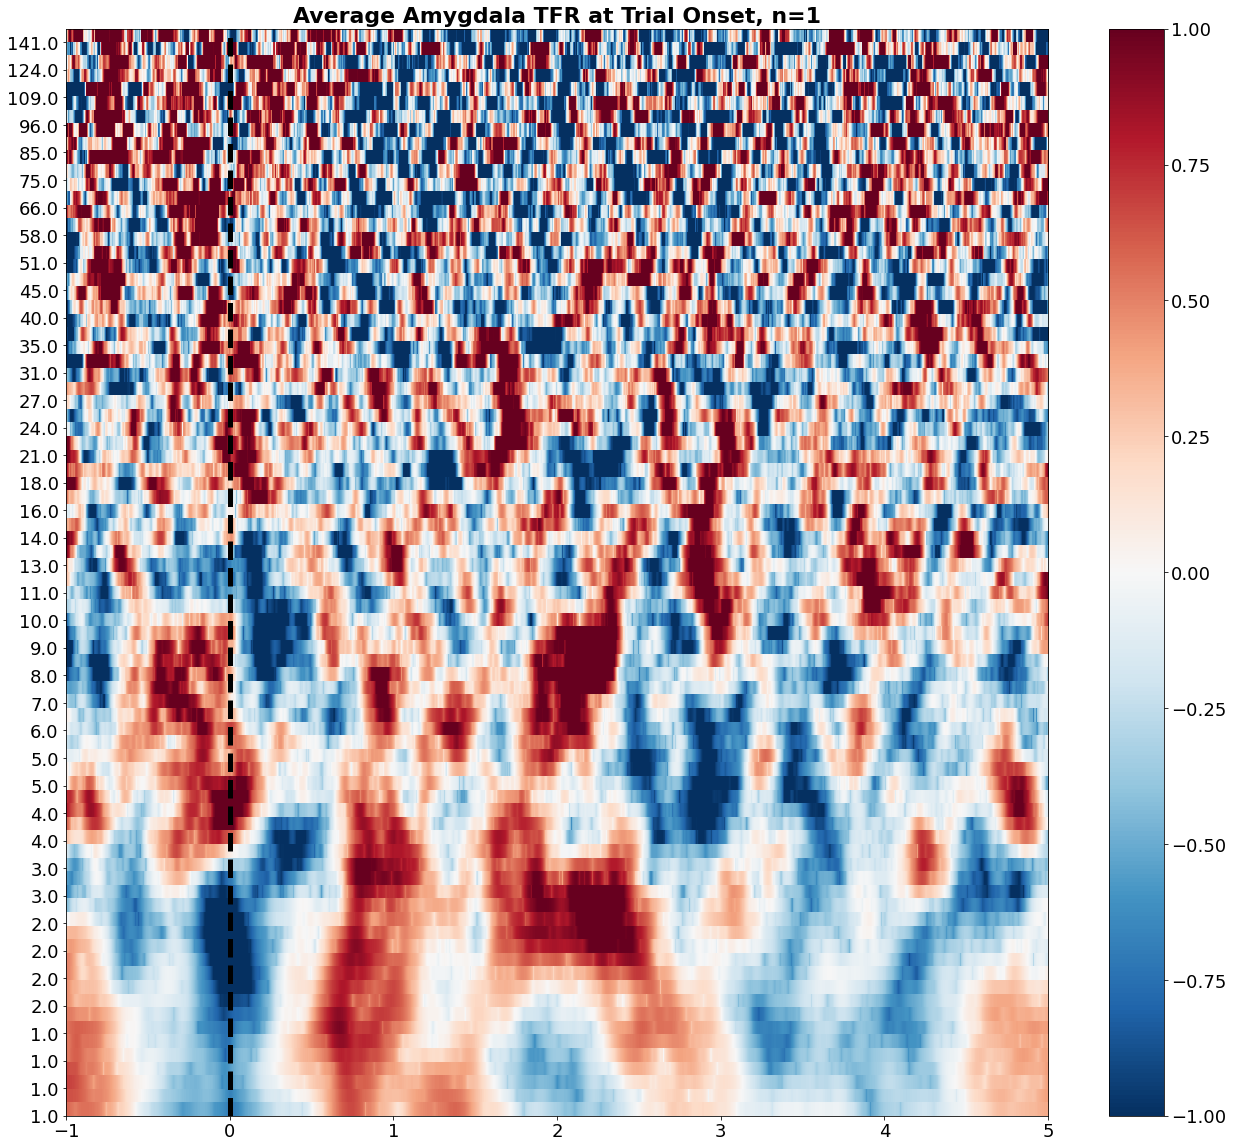

In [31]:
# Plot TFR
plot_average_tfr(roi_pres_TFR, f"Average Amygdala TFR at Trial Onset, n={len(amyg_list)}", subject, 'amyg_trialonset')


### Individual Channels

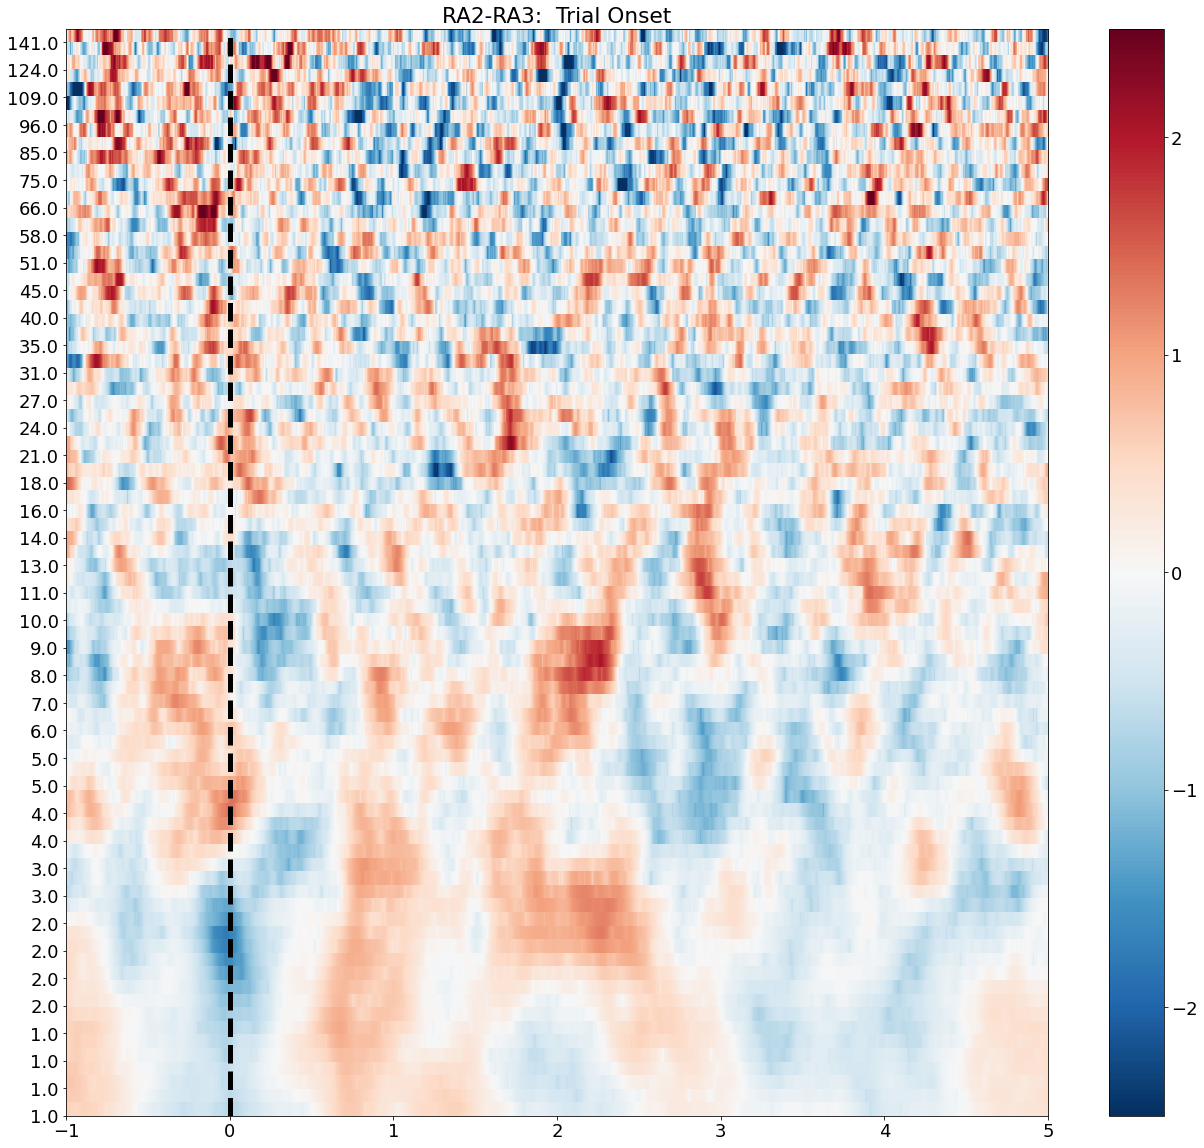

In [32]:
# Plot Channel TFR
for chix, ch in enumerate(roi_pres_TFR.ch_names):

    plot_channel_tfr(roi_pres_TFR, chix, ch, 'Trial Onset')
    


## Cingulate

In [33]:
cing_list

['RAC1-RAC2', 'RAC2-RAC3', 'RAC3-RAC4', 'LOF1-LOF2', 'LAC1-LAC2', 'LAC2-LAC3']

In [34]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(cing_list)


In [35]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [36]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   38.3s remaining:   38.3s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   47.0s finished


Not setting metadata


In [37]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 211, channels : 6, ~2.32 GB>

In [38]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/trial_onset/cing-tfr.h5", overwrite = True)

In [39]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


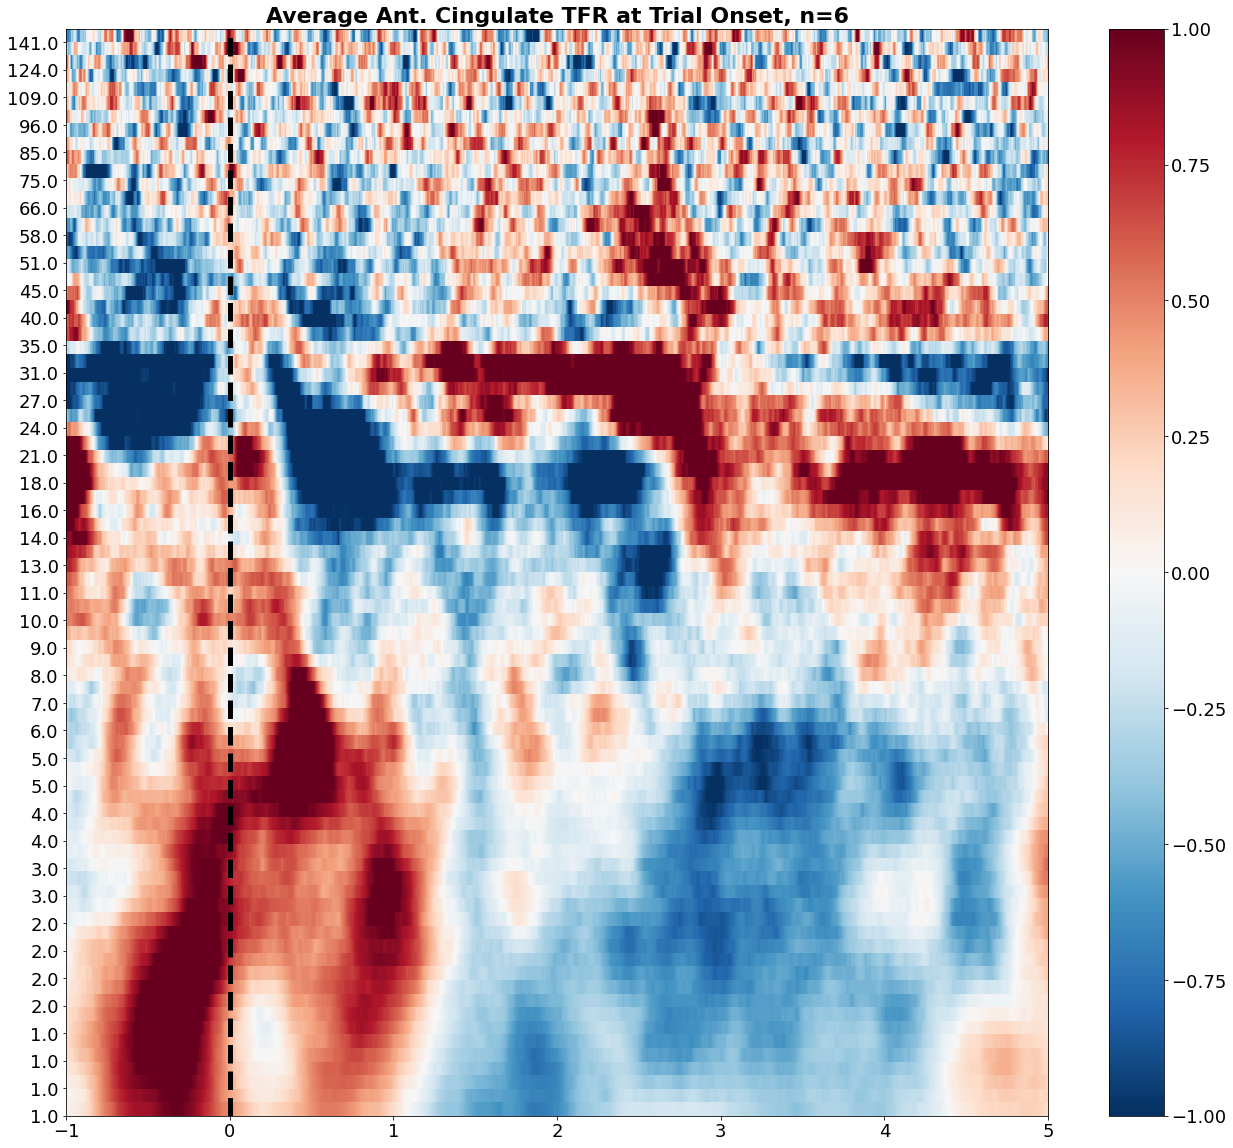

In [40]:
# Plot TFR
plot_average_tfr(roi_pres_TFR, f"Average Ant. Cingulate TFR at Trial Onset, n={len(cing_list)}", subject, 'cing_trialonset')

### Individual Channels

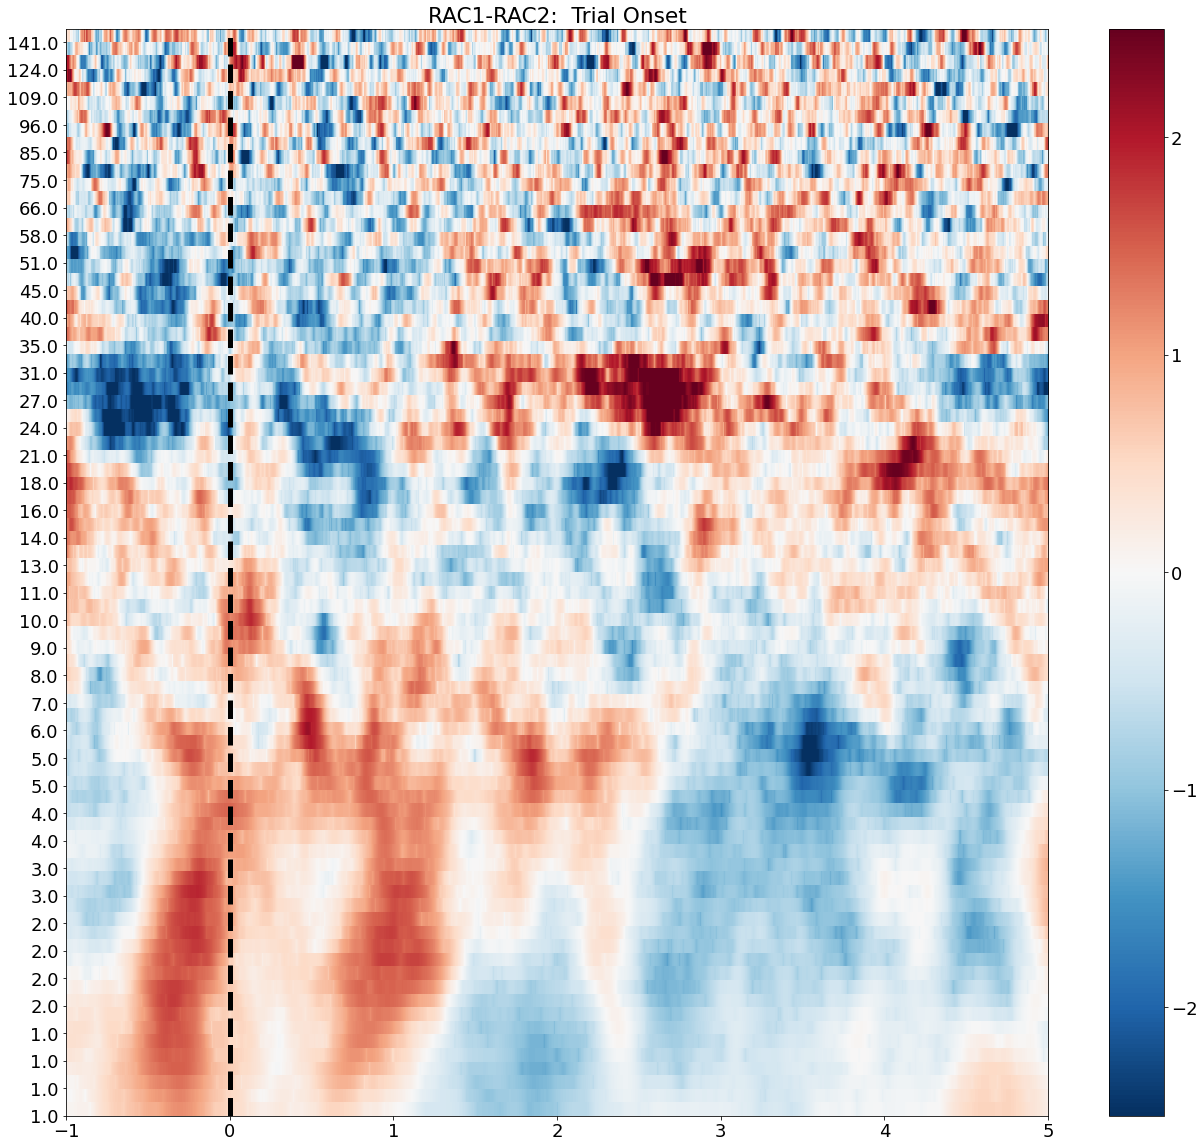

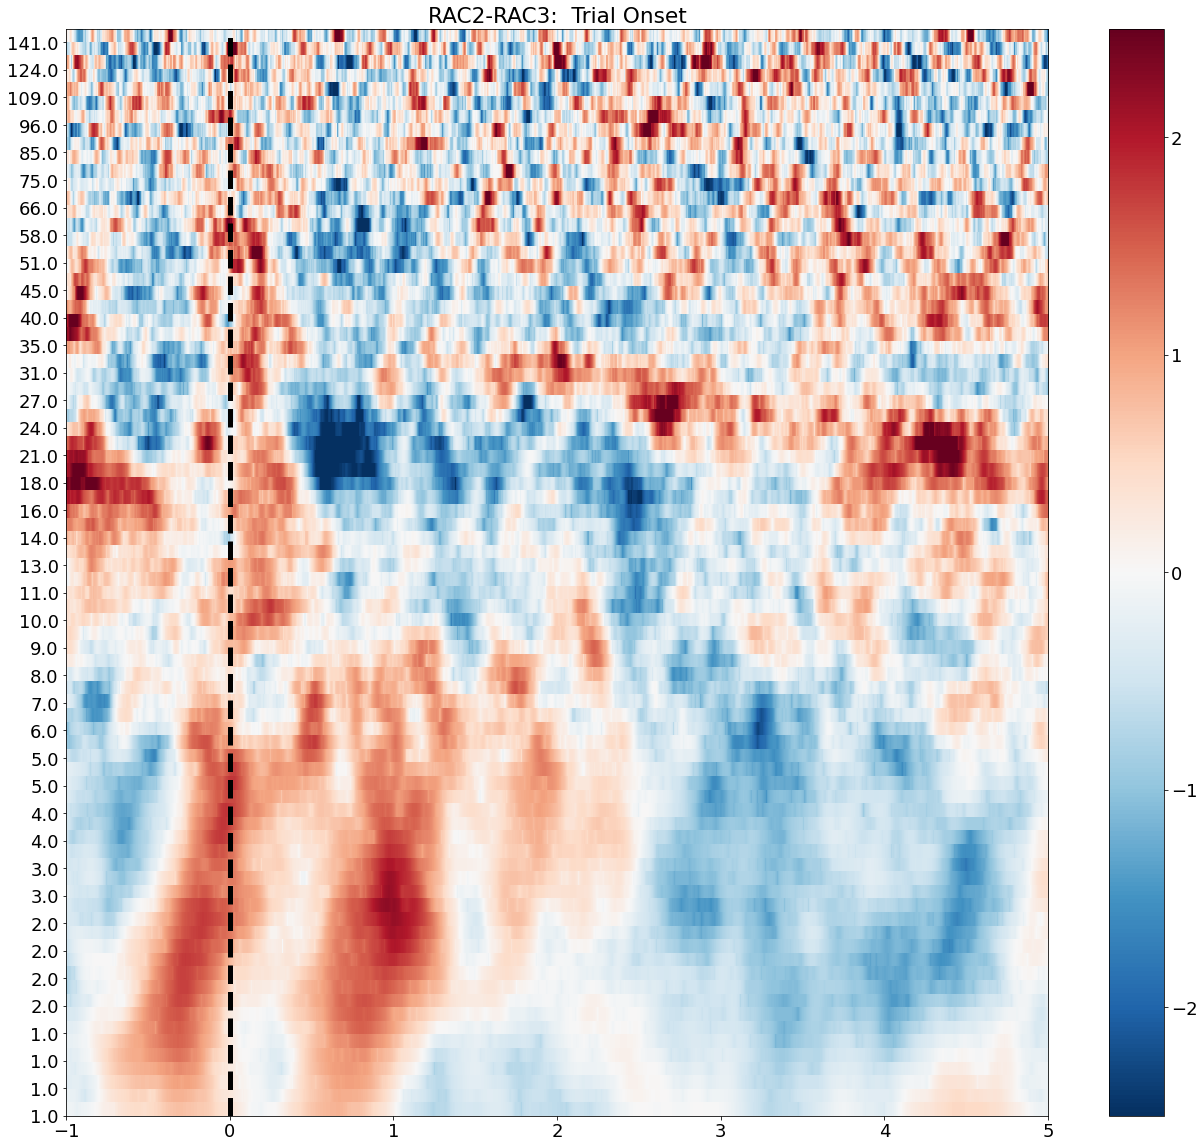

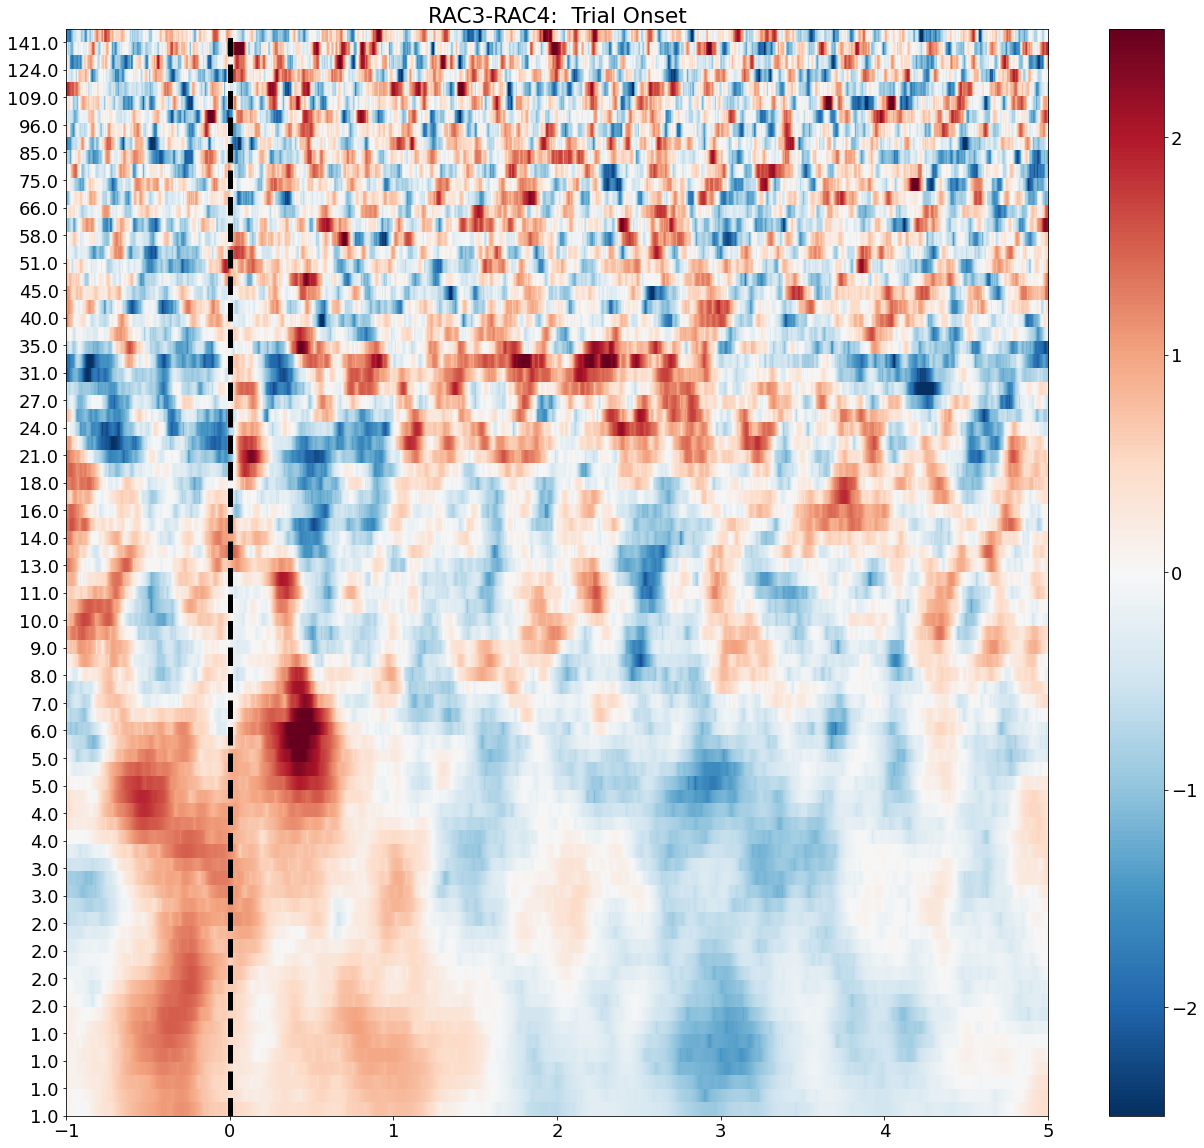

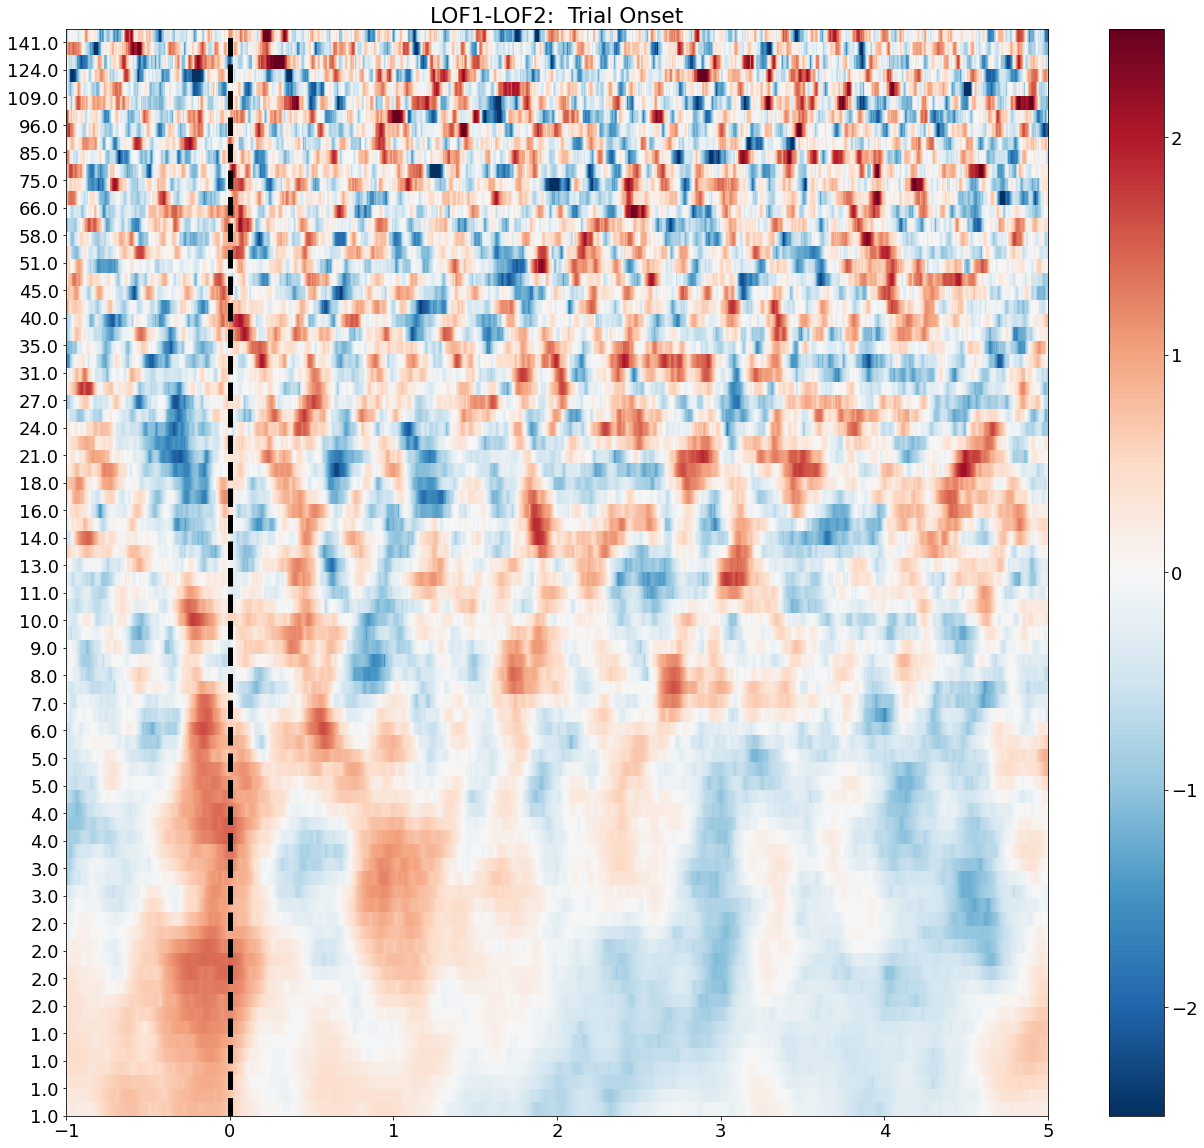

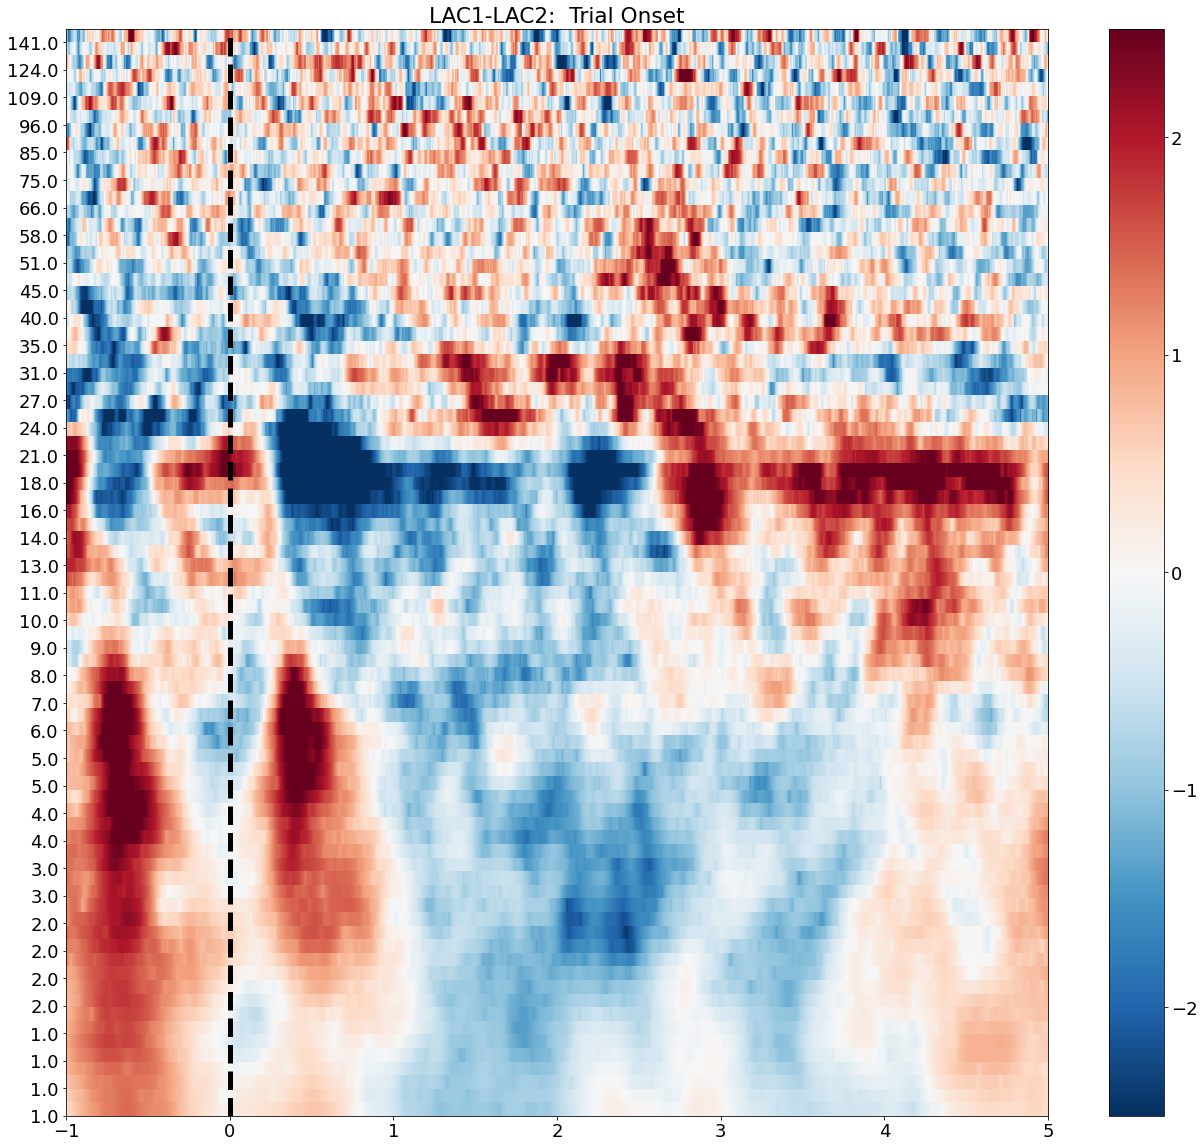

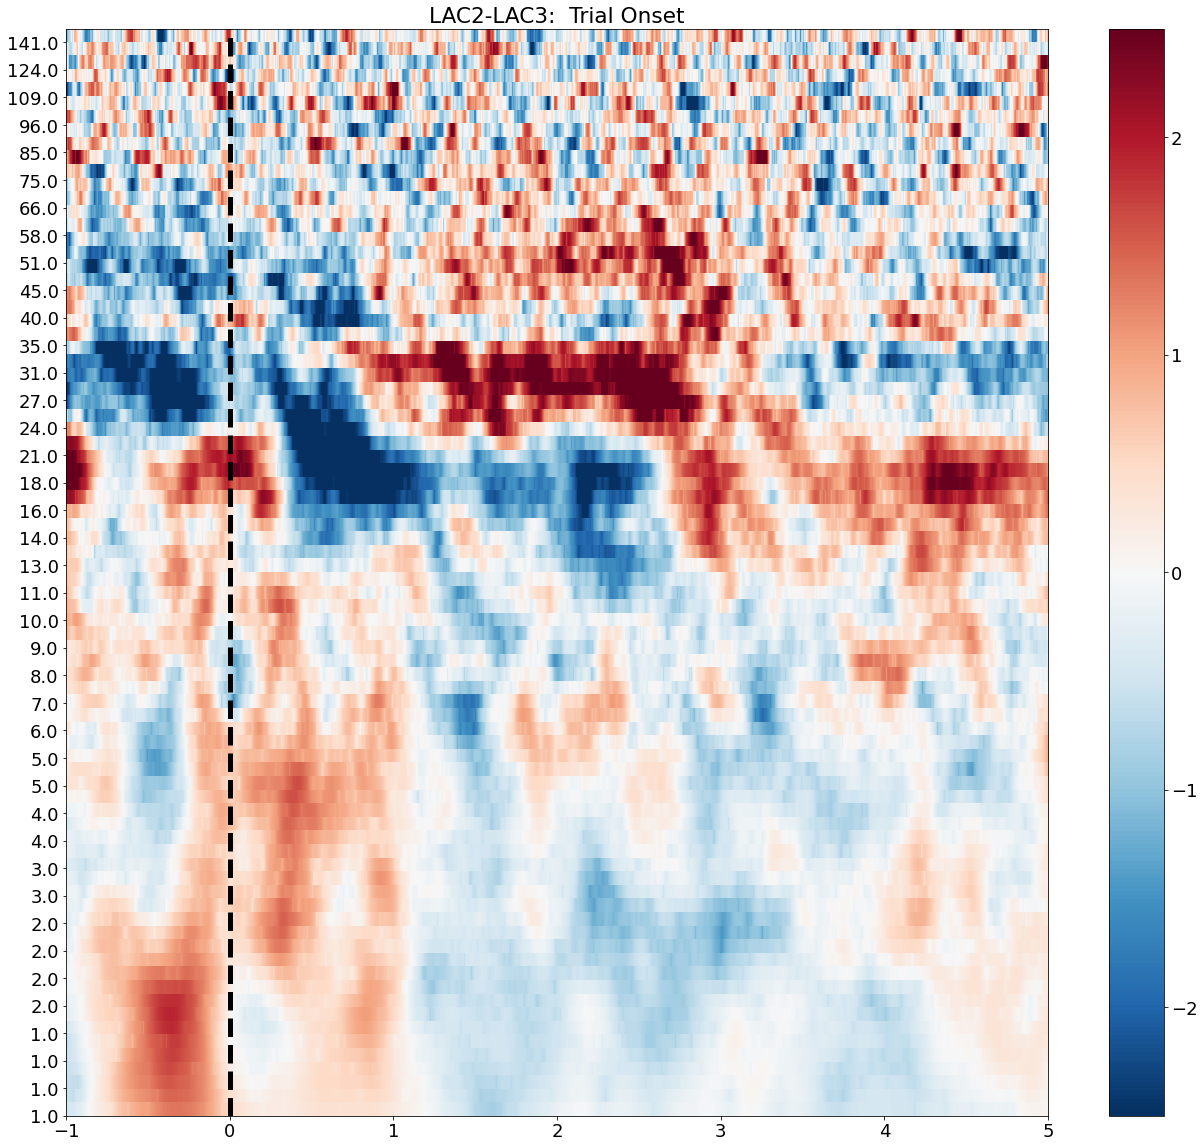

In [41]:
# Plot Channel TFR
for chix, ch in enumerate(roi_pres_TFR.ch_names):

    plot_channel_tfr(roi_pres_TFR, chix, ch, 'Trial Onset')
    


# Control Regions

## dlPFC

In [42]:
dlpfc_list

['ROF9-ROF10',
 'RAC5-RAC6',
 'RAC6-RAC7',
 'LOF7-LOF8',
 'LOF8-LOF9',
 'LOF9-LOF10',
 'LAC4-LAC5',
 'LAC5-LAC6',
 'LAC6-LAC7',
 'LAC7-LAC8']

In [43]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(dlpfc_list)


In [44]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [45]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = compute_TFR(trial_onset_roi,freqs,n_cycles)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   51.3s remaining:   34.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished


Not setting metadata


In [46]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 211, channels : 10, ~3.86 GB>

In [47]:
# save TFRs

roi_pres_TFR.save(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/trial_onset/dlpfc-tfr.h5", overwrite = True)

In [48]:
# Log and zscore

roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,5), logflag=True)

log transforming
z-scoring to baseline


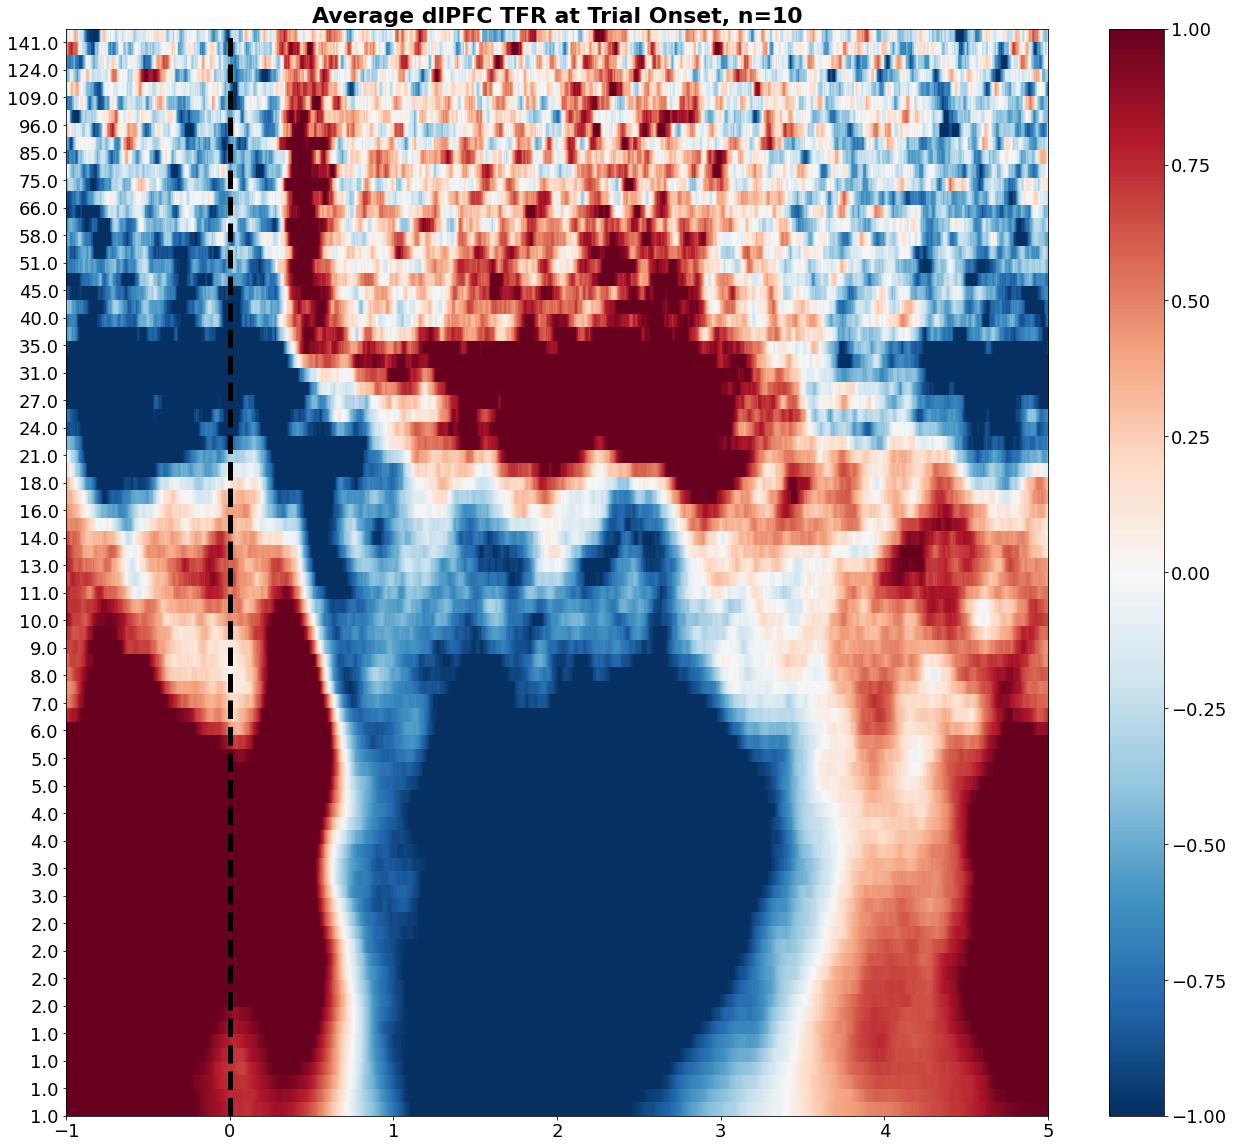

In [49]:
# Plot TFR
plot_average_tfr(roi_pres_TFR, f"Average dlPFC TFR at Trial Onset, n={len(dlpfc_list)}", subject, 'dlpfc_trialonset')

### Individual Channels

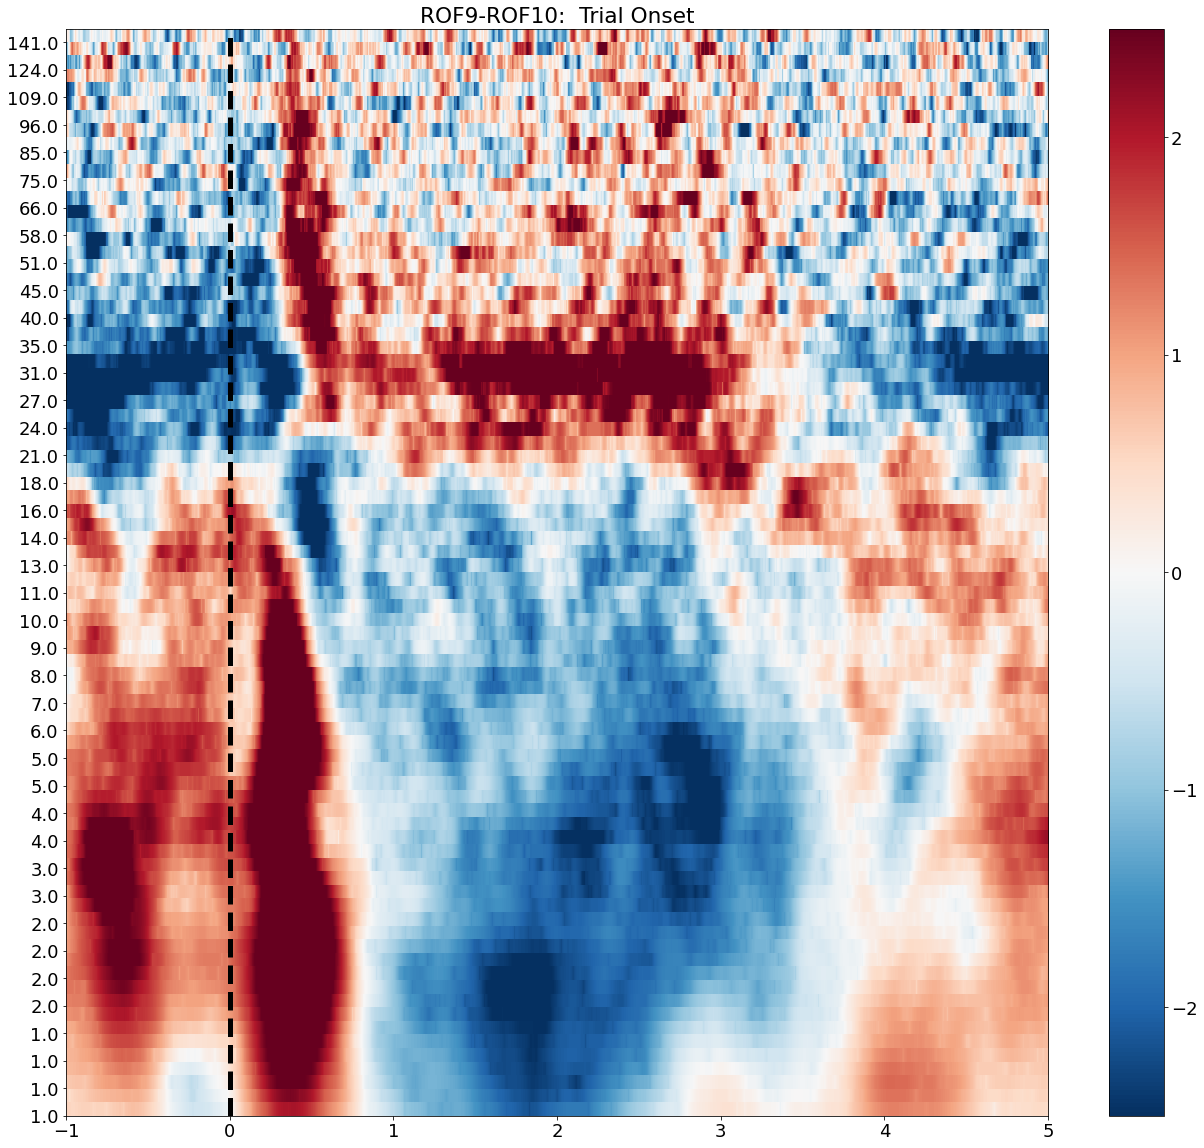

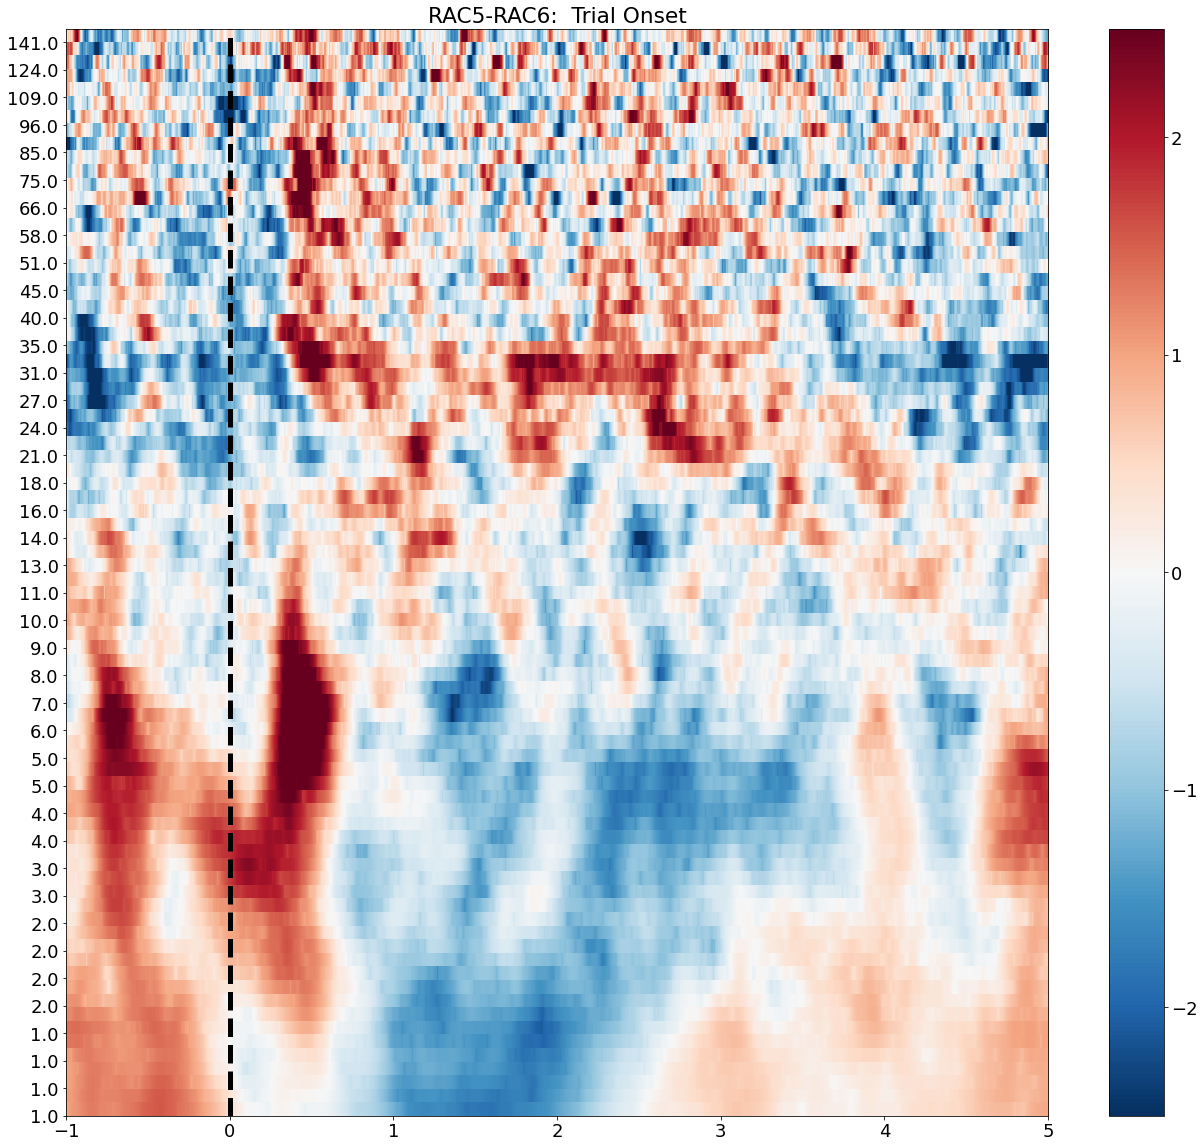

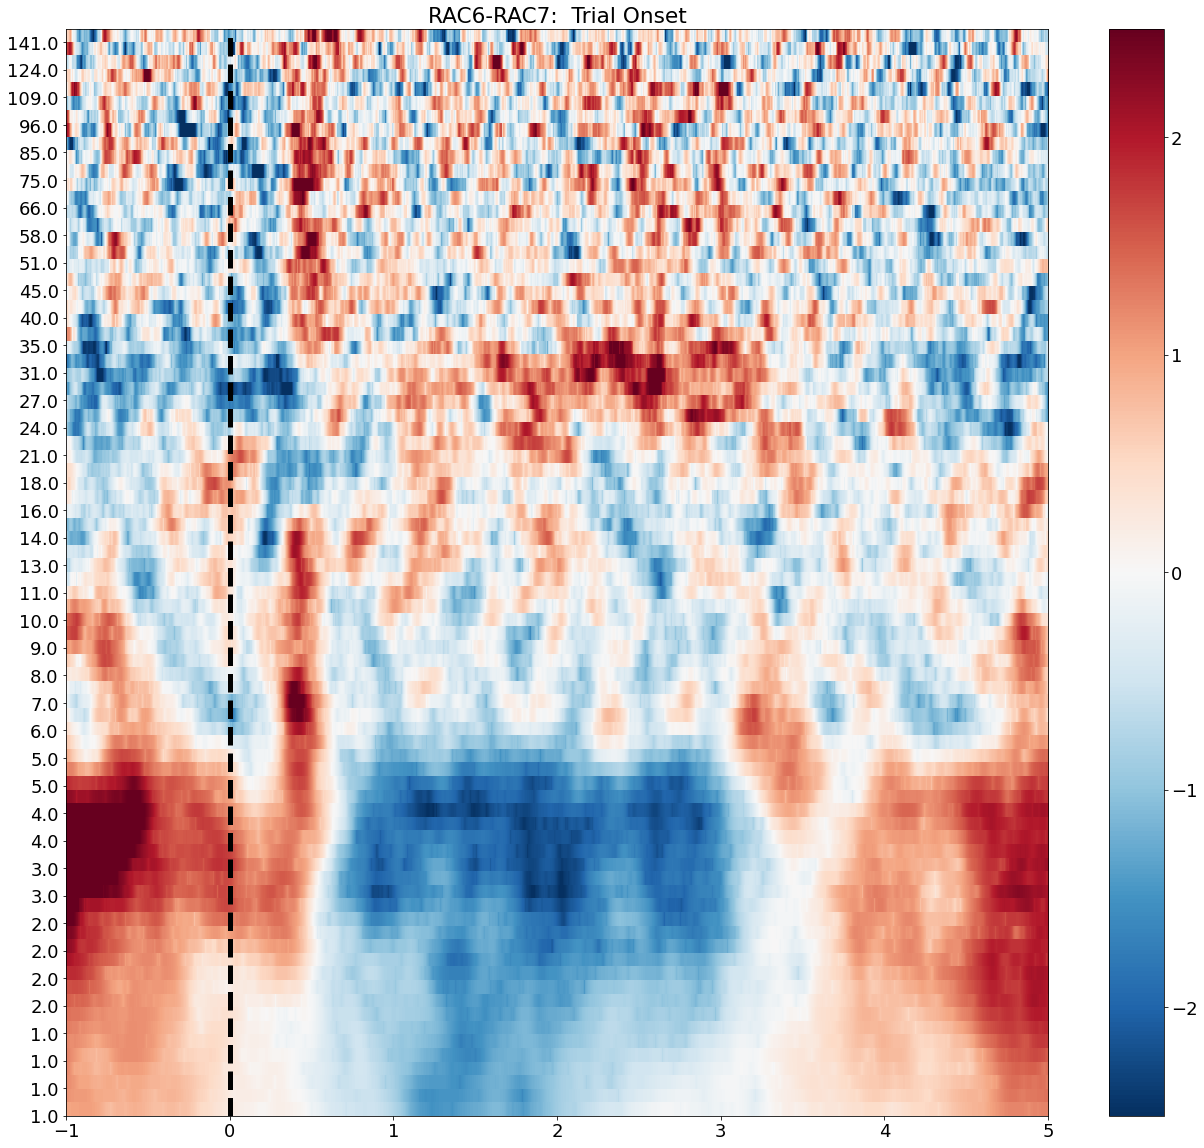

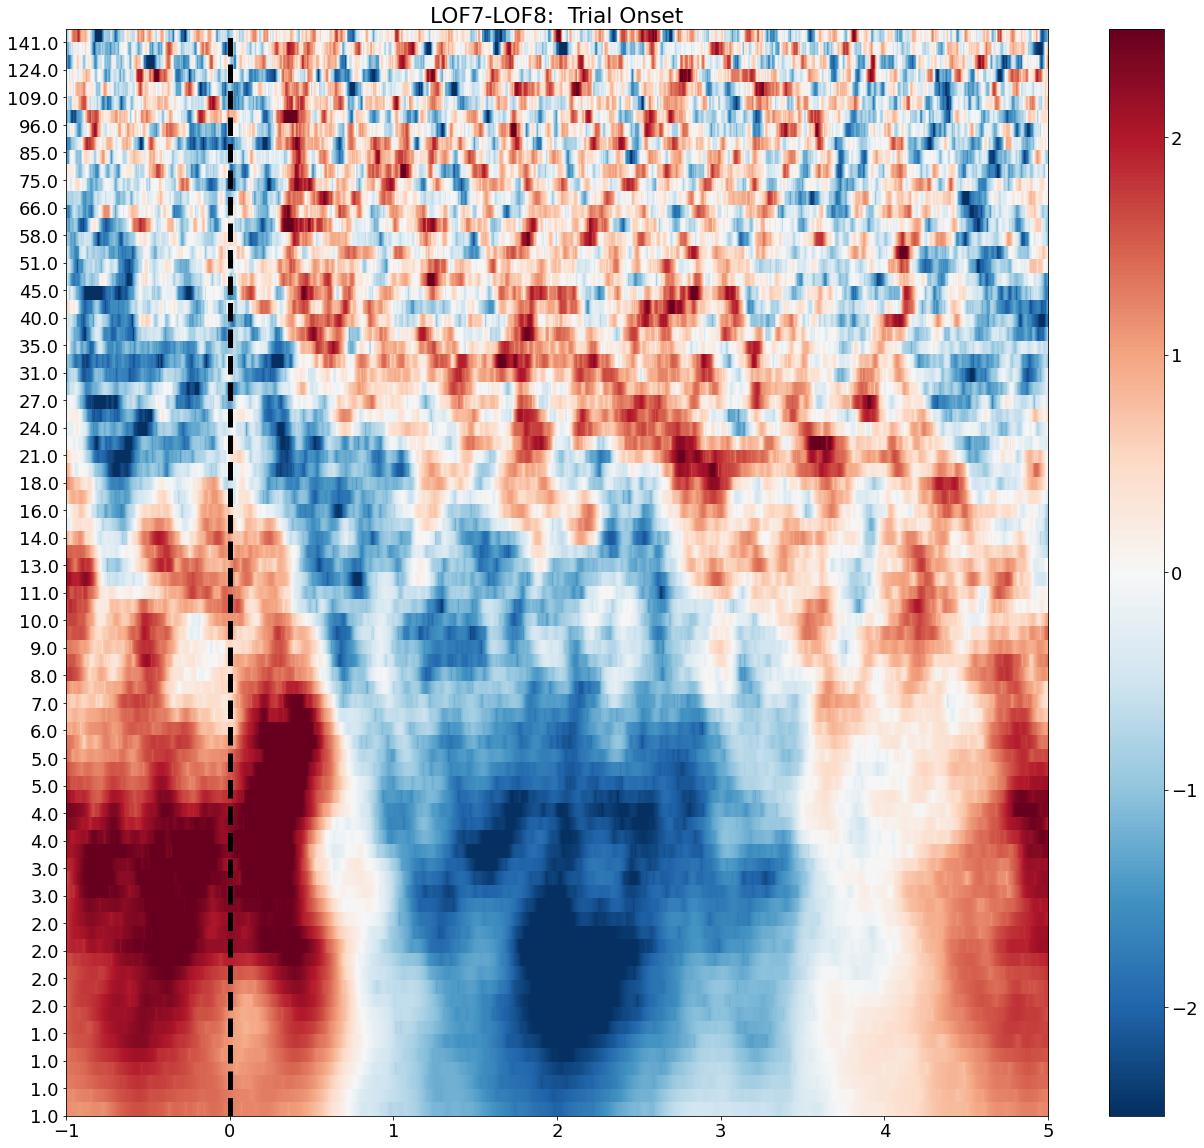

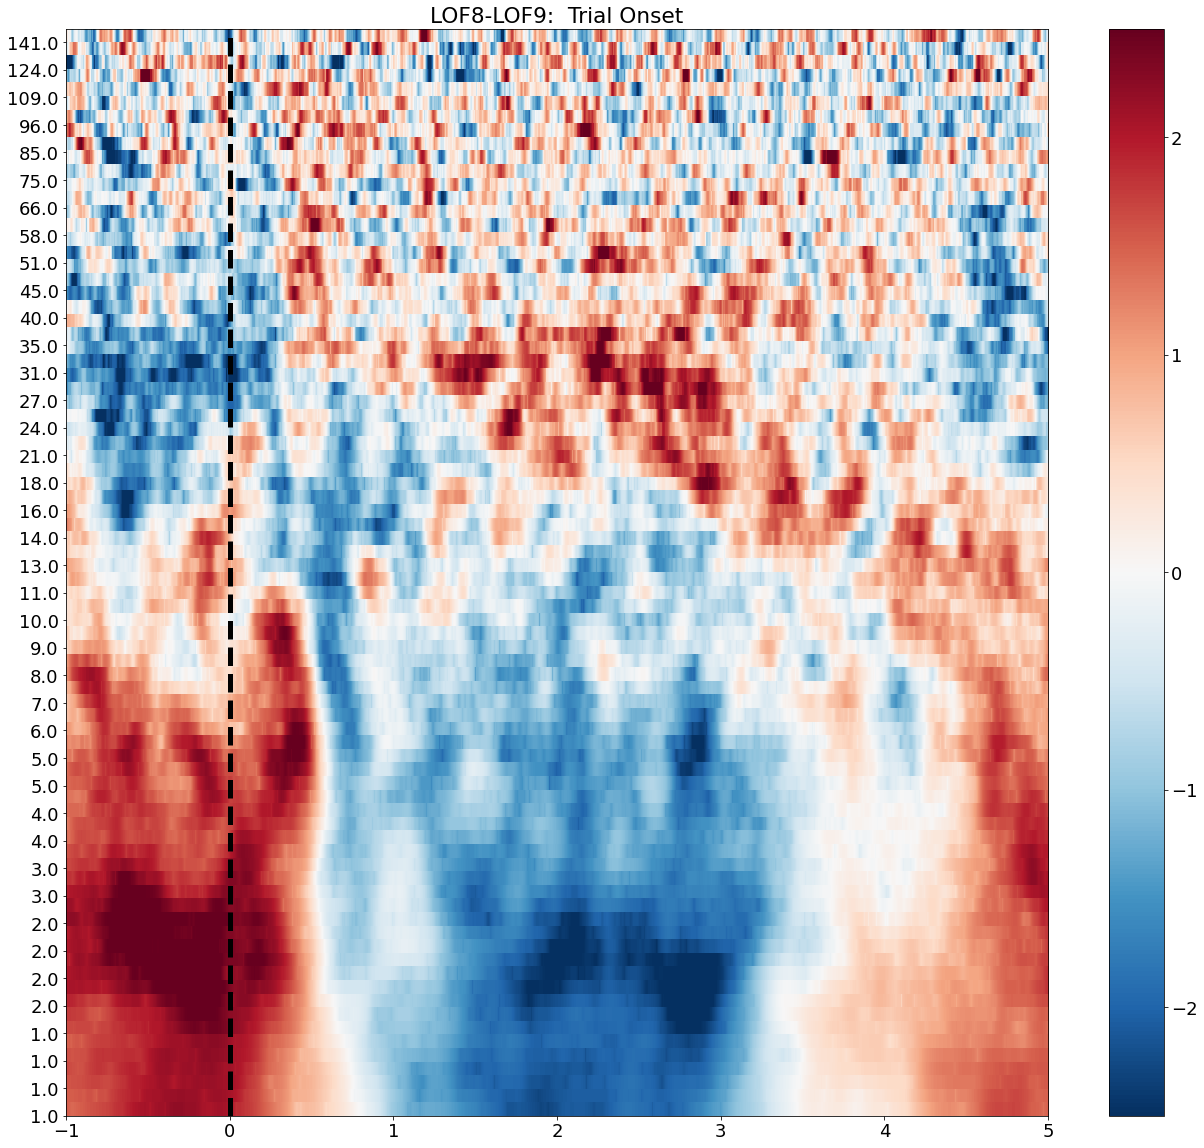

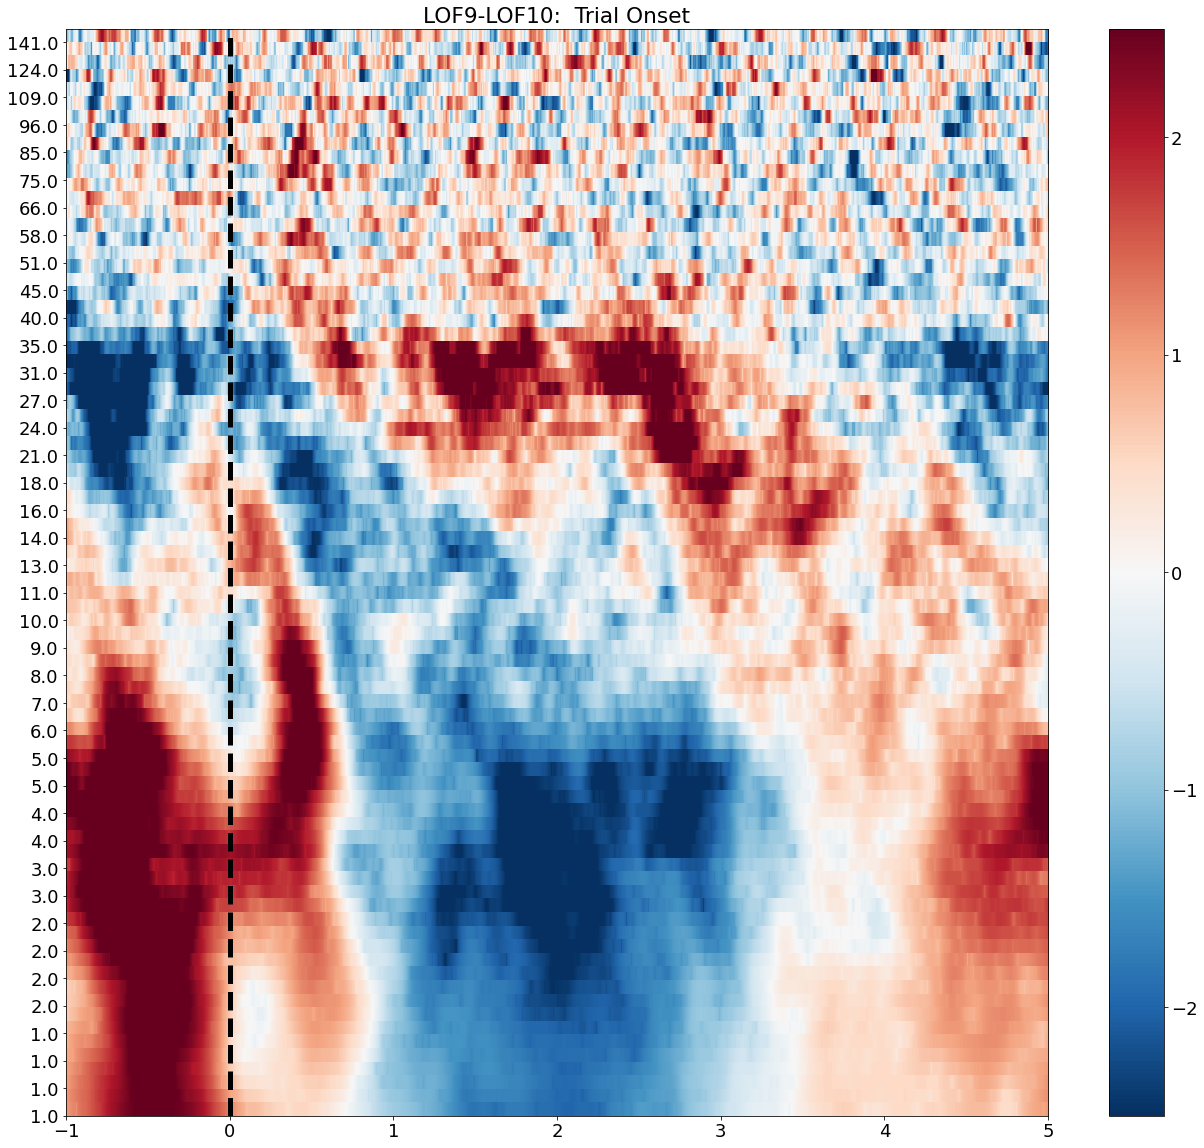

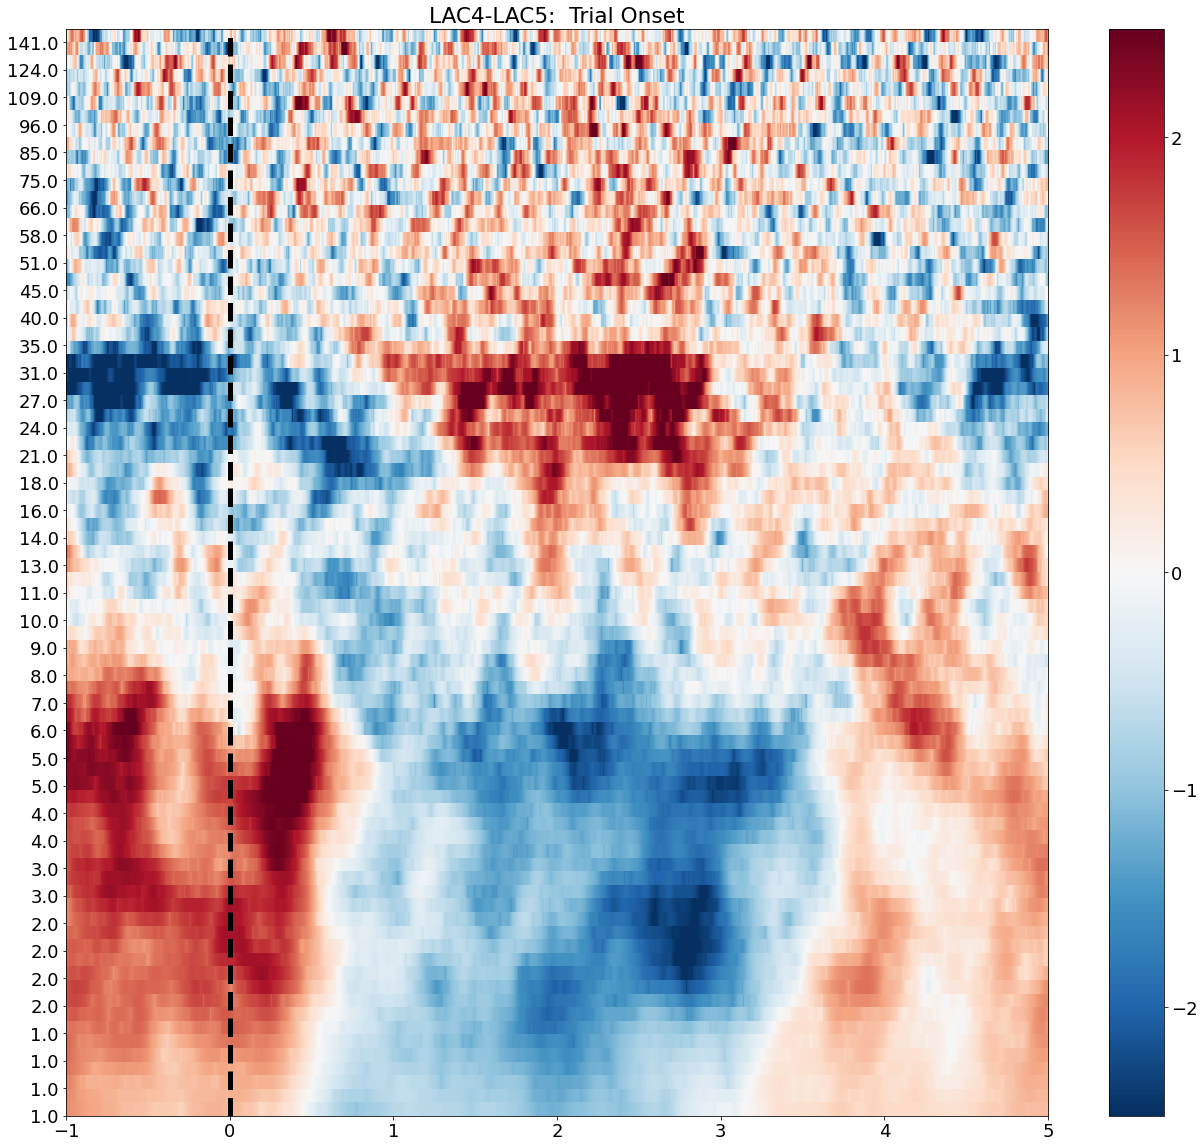

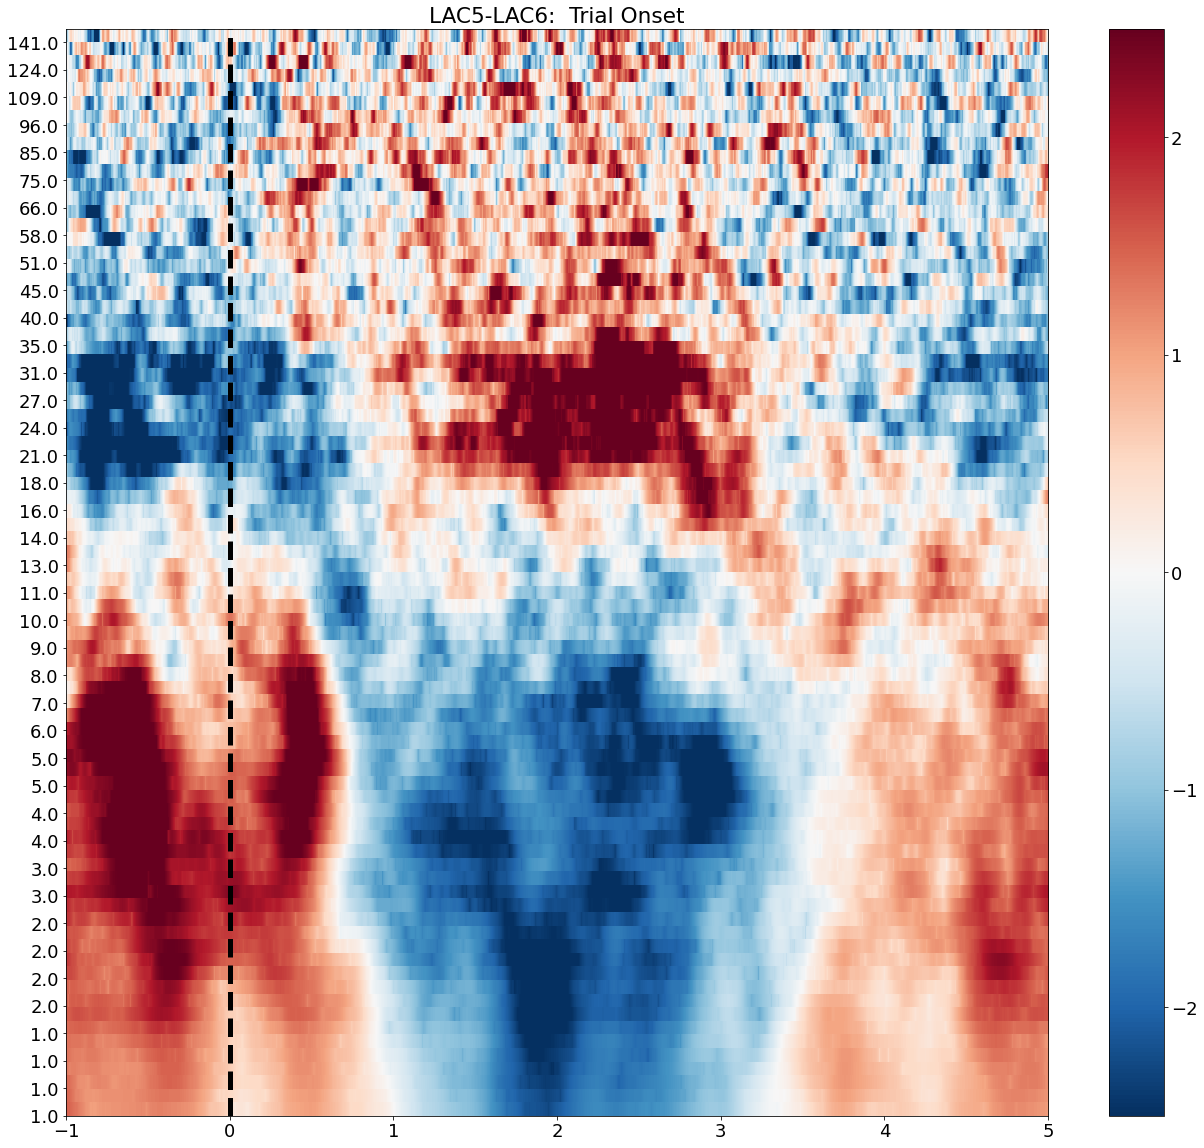

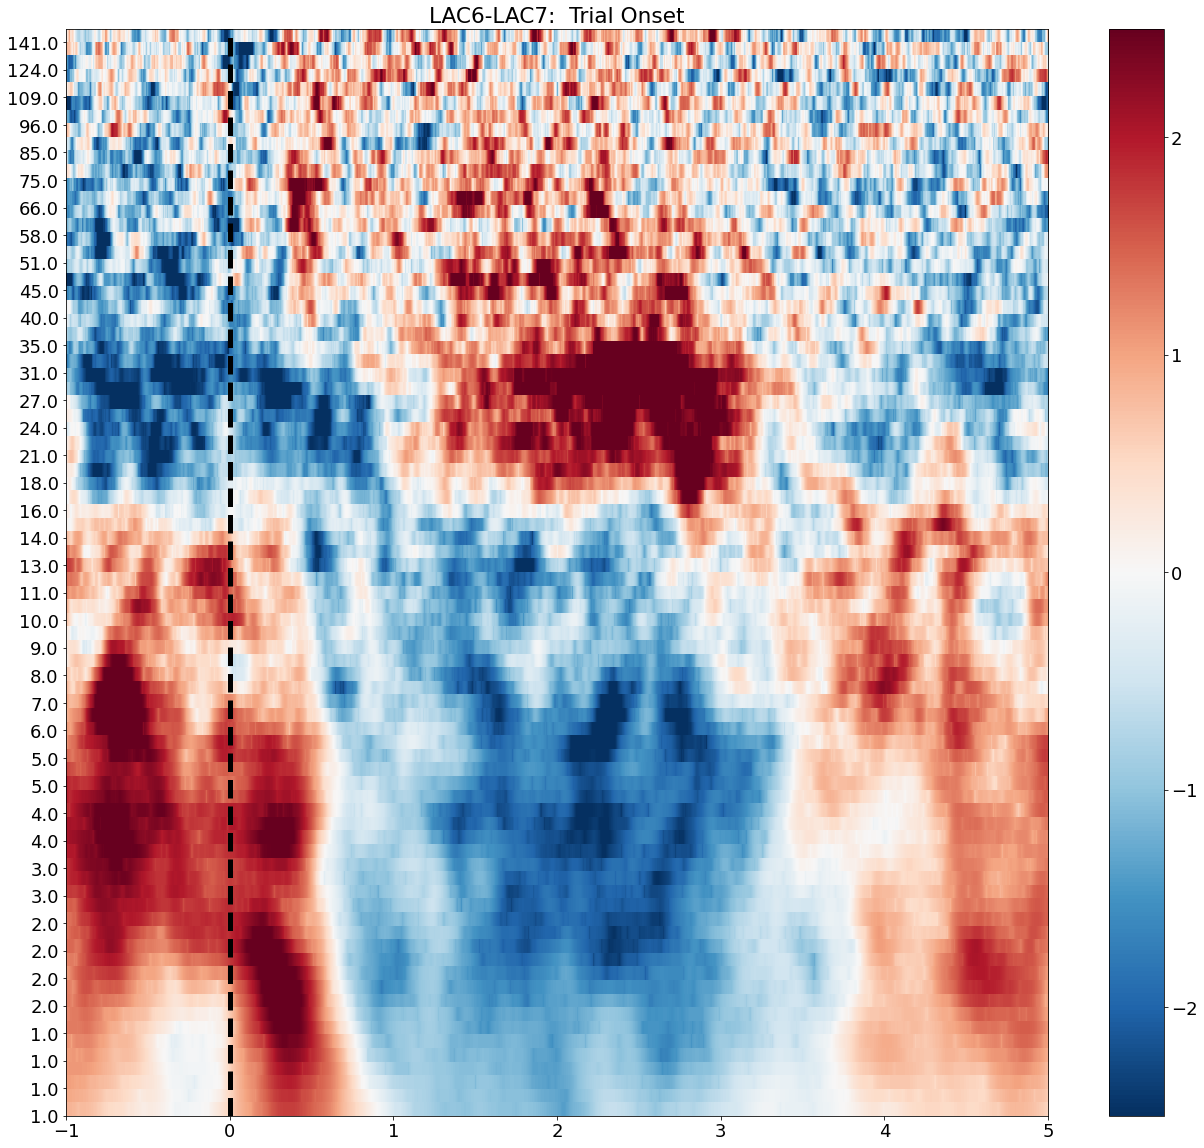

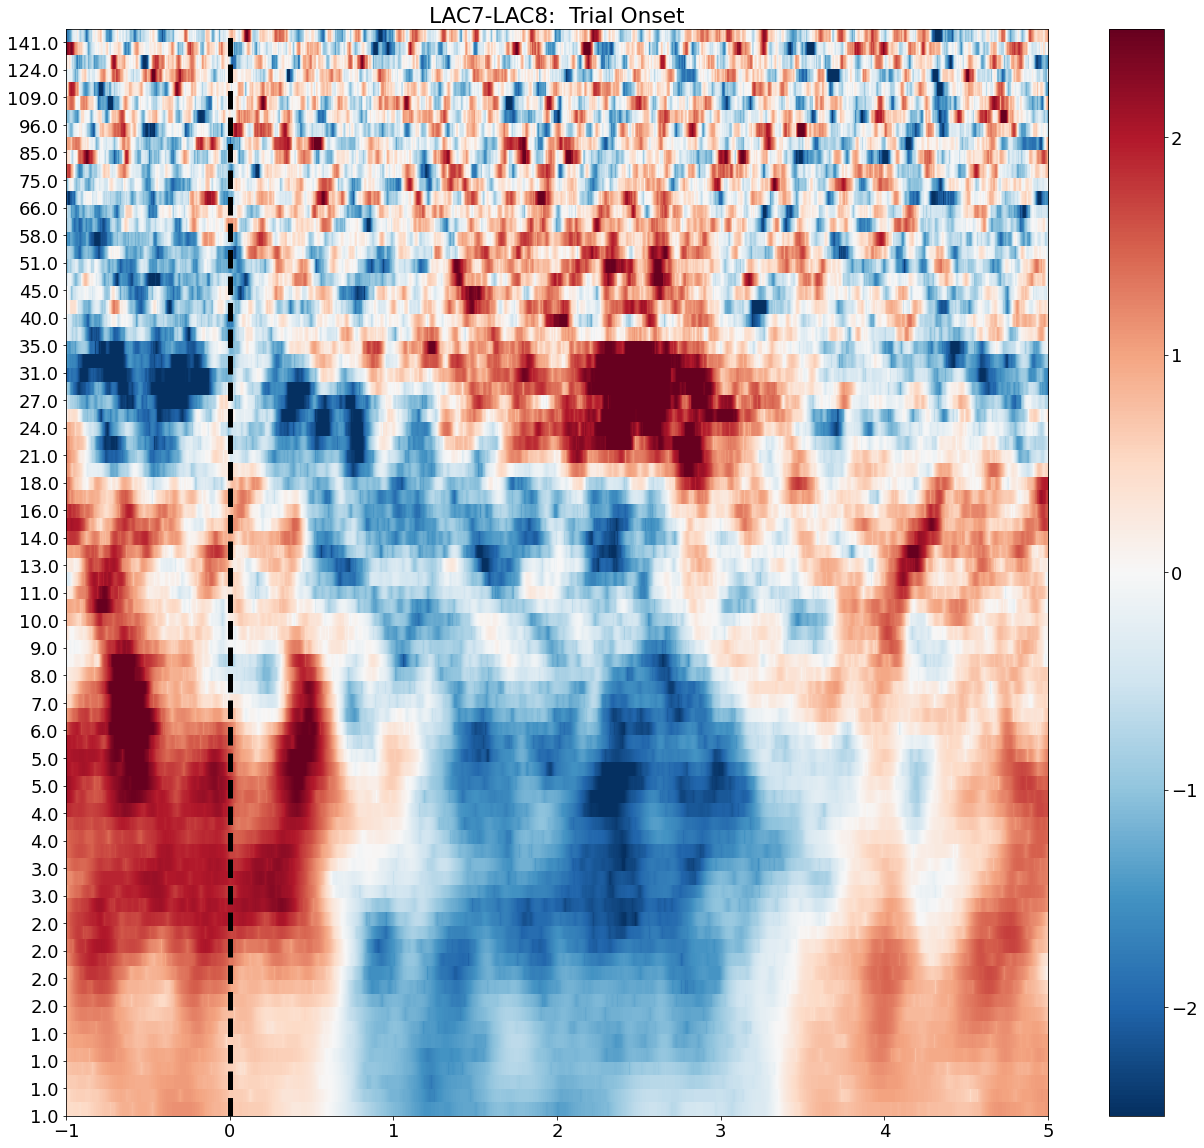

In [50]:
# Plot Channel TFR
for chix, ch in enumerate(roi_pres_TFR.ch_names):

    plot_channel_tfr(roi_pres_TFR, chix, ch, 'Trial Onset')
    
